In this data, you are supposed to predict the Site EUI for each row, given the characteristics of the building and the weather data for the location of the building..

## Importing libraries

In [99]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
import missingno as msno

from category_encoders import TargetEncoder
from sklearn.impute import KNNImputer

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from catboost import CatBoostRegressor

import tqdm
import joblib
import pickle
# serialized your object and saves its binary form

pd.set_option('display.max_columns', 70)
plt.rcParams['axes.spines.top']=False
plt.rcParams['axes.spines.right']=False

style.use('ggplot')
sns.set_palette('Set2')
# blue, orange, green

import warnings
warnings.filterwarnings('ignore')

In [15]:
train = pd.read_csv('train_dataset.csv')
test = pd.read_csv('x_test.csv')

In [16]:
dtrain = train.copy()
dtest = test.copy()

## Statistical data analysis
Let's take a look at the data.

In [17]:
print('Train shape:', dtrain.shape)
print('Test shape:', dtest.shape)

Train shape: (75757, 64)
Test shape: (9705, 63)


In [18]:
train.head()

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,february_max_temp,march_min_temp,march_avg_temp,march_max_temp,april_min_temp,april_avg_temp,april_max_temp,may_min_temp,may_avg_temp,may_max_temp,june_min_temp,june_avg_temp,june_max_temp,july_min_temp,july_avg_temp,july_max_temp,august_min_temp,august_avg_temp,august_max_temp,september_min_temp,september_avg_temp,september_max_temp,october_min_temp,october_avg_temp,october_max_temp,november_min_temp,november_avg_temp,november_max_temp,december_min_temp,december_avg_temp,december_max_temp,cooling_degree_days,heating_degree_days,precipitation_inches,snowfall_inches,snowdepth_inches,avg_temp,days_below_30F,days_below_20F,days_below_10F,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui,id
0,1,State_1,Commercial,Grocery_store_or_food_market,61242.0,1942.0,11.0,2.4,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,1.0,1.0,NaN,248.682615,0
1,1,State_1,Commercial,Warehouse_Distribution_or_Shipping_center,274000.0,1955.0,45.0,1.8,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,NaN,1.0,12.0,26.500150,1
2,1,State_1,Commercial,Retail_Enclosed_mall,280025.0,1951.0,97.0,1.8,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,NaN,1.0,12.0,24.693619,2
3,1,State_1,Commercial,Education_Other_classroom,55325.0,1980.0,46.0,1.8,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,NaN,1.0,12.0,48.406926,3
4,1,State_1,Commercial,Warehouse_Nonrefrigerated,66000.0,1985.0,100.0,2.4,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,1.0,1.0,NaN,3.899395,4


In [19]:
train.describe()

,Year_Factor,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,february_max_temp,march_min_temp,march_avg_temp,march_max_temp,april_min_temp,april_avg_temp,april_max_temp,may_min_temp,may_avg_temp,may_max_temp,june_min_temp,june_avg_temp,june_max_temp,july_min_temp,july_avg_temp,july_max_temp,august_min_temp,august_avg_temp,august_max_temp,september_min_temp,september_avg_temp,september_max_temp,october_min_temp,october_avg_temp,october_max_temp,november_min_temp,november_avg_temp,november_max_temp,december_min_temp,december_avg_temp,december_max_temp,cooling_degree_days,heating_degree_days,precipitation_inches,snowfall_inches,snowdepth_inches,avg_temp,days_below_30F,days_below_20F,days_below_10F,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui,id
count,75757.000000,7.575700e+04,73920.000000,49048.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,34675.000000,33946.000000,34675.000000,29961.000000,75757.000000,75757.000000
mean,4.367755,1.659839e+05,1952.306764,61.048605,39.506323,11.432343,34.310468,59.054952,11.720567,35.526837,58.486278,21.606281,44.469292,70.897831,32.037171,53.784863,82.661932,44.706179,63.742547,88.987856,51.131763,71.066384,91.400280,60.571604,76.596879,95.543950,58.515068,75.348749,92.572581,50.791689,69.597545,92.171139,38.210911,58.727038,81.135671,28.630397,48.123133,71.202397,22.736777,41.625569,64.496852,1202.250446,4324.957390,42.430651,29.136379,164.862455,56.176705,48.756511,17.447932,4.886532,0.876764,82.709809,14.058701,0.279539,0.002442,66.552675,62.779974,4.190601,109.142051,82.584693,37878.000000
std,1.471441,2.468758e+05,37.053619,28.663683,60.656596,9.381027,6.996108,5.355458,12.577272,8.866697,8.414611,10.004303,6.657142,7.680982,5.577279,2.500473,4.101028,4.200319,2.792919,2.864669,3.415926,2.861681,3.604068,4.177109,4.090275,4.157118,4.441992,3.818895,4.139685,4.290884,3.603773,5.011708,5.093899,2.641300,5.579513,7.153244,4.094207,4.373374,9.014047,5.869386,6.054104,391.561780,824.366727,10.592205,17.810894,175.275869,2.241940,27.587124,14.469435,7.071221,2.894244,25.282913,10.943996,2.252323,0.142140,131.147834,130.308106,6.458789,50.699751,58.255403,21869.306509
min,1.000000,9.430000e+02,0.000000,0.000000,-6.400000,-19.000000,10.806452,42.000000,-13.000000,13.250000,38.000000,-9.000000,25.854839,53.000000,15.000000,40.280000,62.000000,23.000000,46.950000,64.000000,30.000000,54.100000,67.000000,37.000000,54.822581,65.000000,31.000000,56.693548,66.000000,26.000000,53.600000,64.000000,18.000000,44.693548,59.000000,4.000000,30.766667,53.000000,-16.000000,23.790323,42.000000,0.000000,398.000000,0.000000,0.000000,0.000000,44.512329,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,12.000000,1.001169,0.000000
25%,3.000000,6.237900e+04,1927.000000,40.000000,11.900000,6.000000,29.827586,56.000000,2.000000,31.625000,55.000000,13.000000,38.096774,62.000000,26.000000,52.333333,80.000000,42.000000,62.790323,88.000000,50.000000,70.983333,89.000000,57.000000,76.145161,95.000000,57.000000,74.516129,90.000000,47.000000,68.200000,91.000000,35.000000,58.048387,78.000000,23.000000,45.250000,69.000000,17.000000,38.532258,60.000000,1128.000000,3978

In [20]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75757 entries, 0 to 75756
Data columns (total 64 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Year_Factor                75757 non-null  int64  
 1   State_Factor               75757 non-null  object 
 2   building_class             75757 non-null  object 
 3   facility_type              75757 non-null  object 
 4   floor_area                 75757 non-null  float64
 5   year_built                 73920 non-null  float64
 6   energy_star_rating         49048 non-null  float64
 7   ELEVATION                  75757 non-null  float64
 8   january_min_temp           75757 non-null  int64  
 9   january_avg_temp           75757 non-null  float64
 10  january_max_temp           75757 non-null  int64  
 11  february_min_temp          75757 non-null  int64  
 12  february_avg_temp          75757 non-null  float64
 13  february_max_temp          75757 non-null  int

There are only 3 categorical features and the rest are numerical features.

In [21]:
train.columns

Index(['Year_Factor', 'State_Factor', 'building_class', 'facility_type',
       'floor_area', 'year_built', 'energy_star_rating', 'ELEVATION',
       'january_min_temp', 'january_avg_temp', 'january_max_temp',
       'february_min_temp', 'february_avg_temp', 'february_max_temp',
       'march_min_temp', 'march_avg_temp', 'march_max_temp', 'april_min_temp',
       'april_avg_temp', 'april_max_temp', 'may_min_temp', 'may_avg_temp',
       'may_max_temp', 'june_min_temp', 'june_avg_temp', 'june_max_temp',
       'july_min_temp', 'july_avg_temp', 'july_max_temp', 'august_min_temp',
       'august_avg_temp', 'august_max_temp', 'september_min_temp',
       'september_avg_temp', 'september_max_temp', 'october_min_temp',
       'october_avg_temp', 'october_max_temp', 'november_min_temp',
       'november_avg_temp', 'november_max_temp', 'december_min_temp',
       'december_avg_temp', 'december_max_temp', 'cooling_degree_days',
       'heating_degree_days', 'precipitation_inches', 'snowfall_inc

In [22]:
train.isna().sum()

Year_Factor                      0
State_Factor                     0
building_class                   0
facility_type                    0
floor_area                       0
                             ...  
direction_peak_wind_speed    41811
max_wind_speed               41082
days_with_fog                45796
site_eui                         0
id                               0
Length: 64, dtype: int64

We are going to rename some columns.

In [23]:
dtrain.rename(columns={
    'Year_Factor': 'year_factor',
    'State_Factor': 'state_factor',
    'ELEVATION': 'elevation',
    'id': 'building_id'
}, inplace=True)

dtest.rename(columns={
    'Year_Factor': 'year_factor',
    'State_Factor': 'state_factor',
    'ELEVATION': 'elevation',
    'id': 'building_id'
}, inplace=True)


<Axes: >

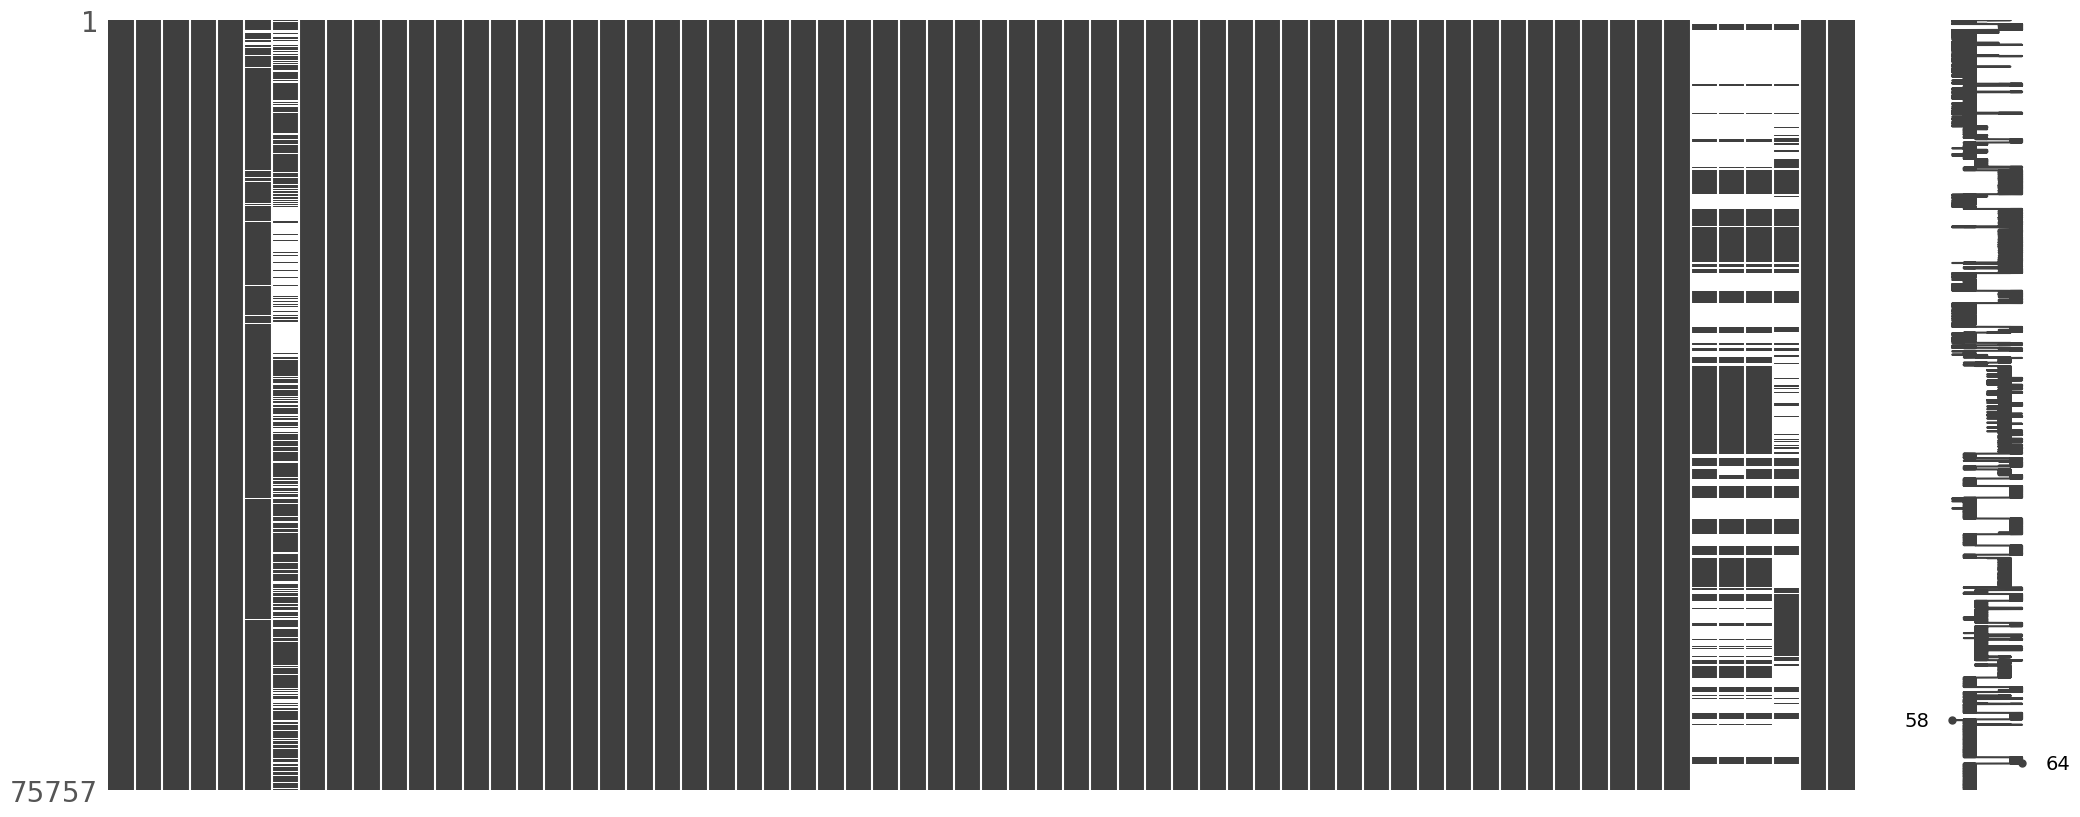

In [24]:
msno.matrix(dtrain)

<Axes: >

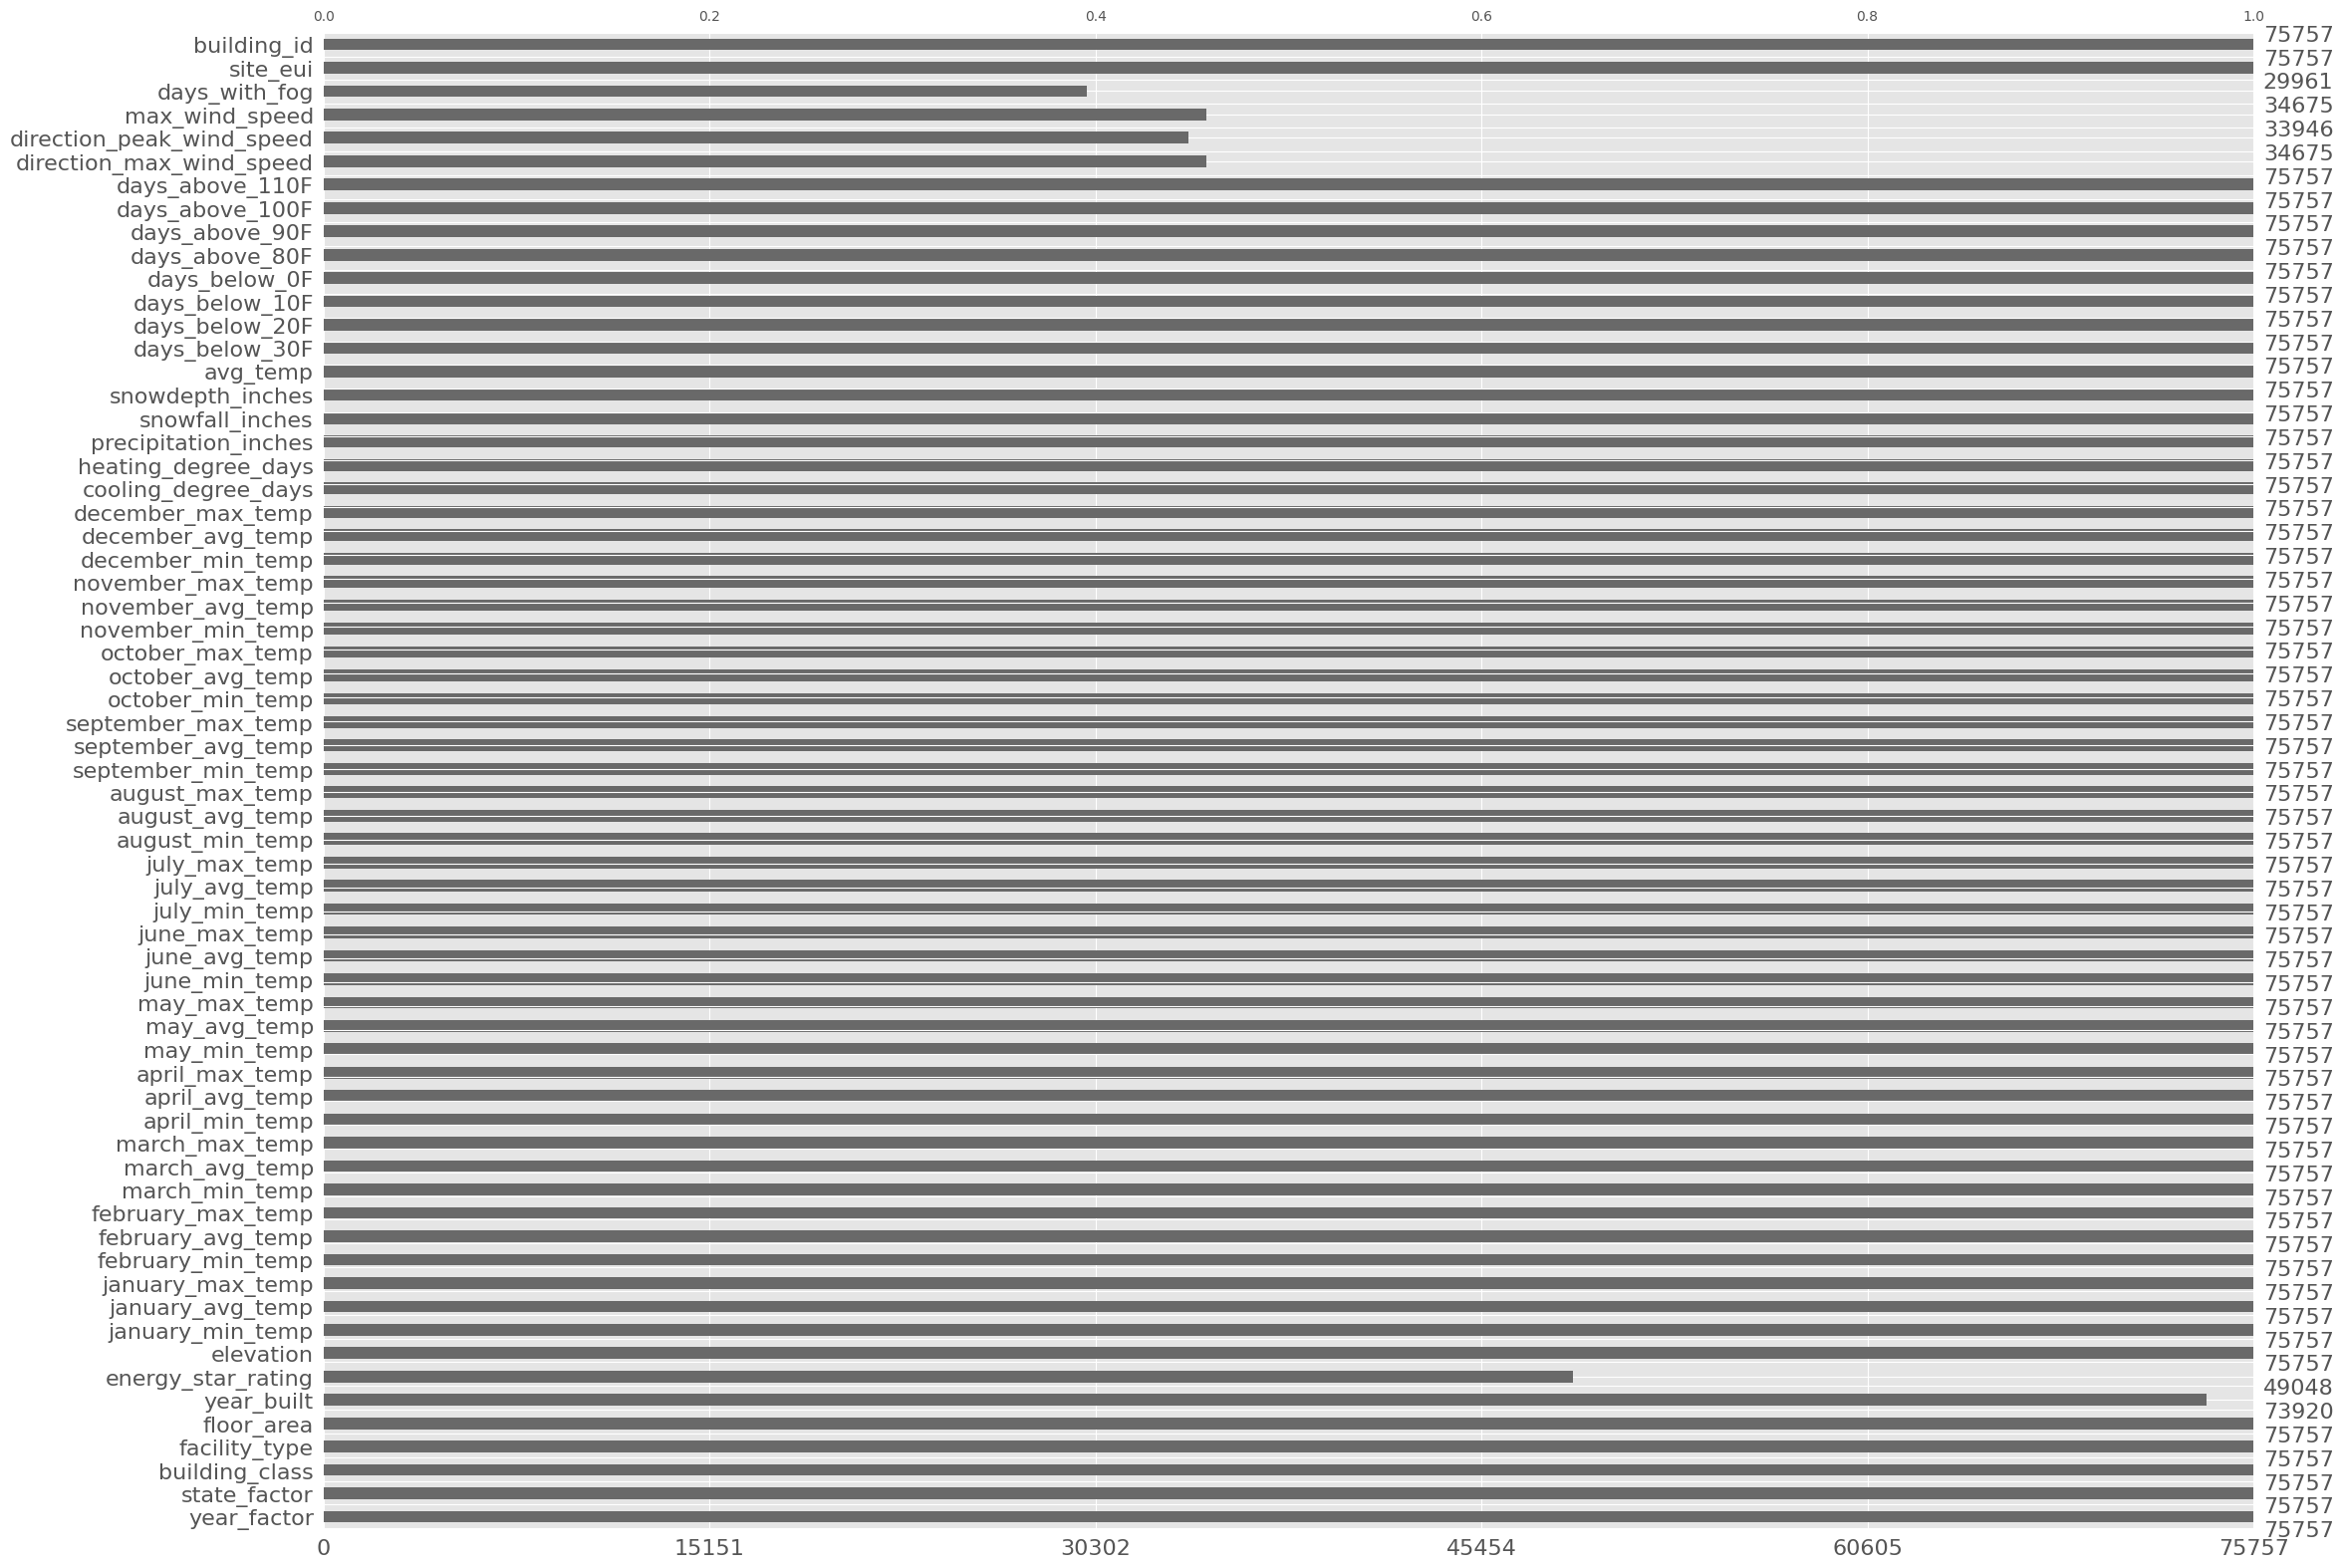

In [25]:
msno.bar(dtrain)

There are 64 columns in the train dataset in which 6 columns have missing values. Let's see those columns.

In [26]:
[(column, dtrain[column].isna().sum()) for column in dtrain.columns if dtrain[column].isna().sum() > 0]

[('year_built', 1837),
 ('energy_star_rating', 26709),
 ('direction_max_wind_speed', 41082),
 ('direction_peak_wind_speed', 41811),
 ('max_wind_speed', 41082),
 ('days_with_fog', 45796)]

In [27]:
print([col for col in dtrain if dtrain[col].nunique()==1])
print([col for col in dtest if dtest[col].nunique()==1])

[]
['year_factor', 'days_above_110F']


In [28]:
print(dtrain.duplicated().sum())
print(dtest.duplicated().sum())

0
0


In [29]:
dtest[['year_factor', 'days_above_110F']]

,year_factor,days_above_110F
0,7,0
1,7,0
2,7,0
3,7,0
4,7,0
...,...,...
9700,7,0
9701,7,0
9702,7,0
9703,7,0


We have 2 columns in the test dataset in which they have constant values.

## Exploring data using visualization

<Axes: xlabel='State_Factor', ylabel='count'>

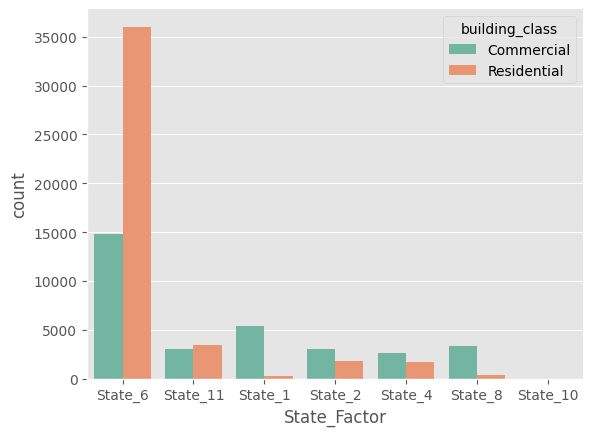

In [30]:
sns.countplot(x='State_Factor', hue='building_class', data=train, order=train['State_Factor'].value_counts().index)

<Axes: ylabel='State_Factor'>

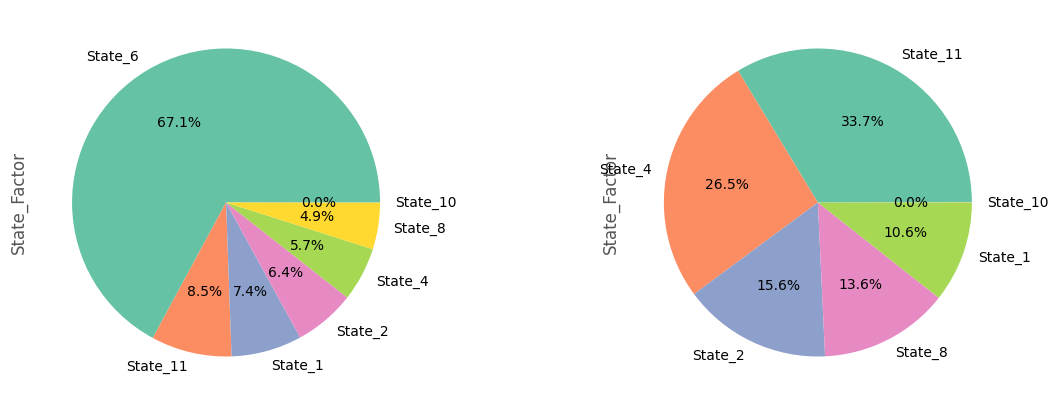

In [31]:
# Percentage of data belonging to both Train and Test data

plt.figure(figsize=(14,5))
plt.subplot(1, 2, 1)
train['State_Factor'].value_counts().plot(kind='pie', autopct='%1.1f%%')

plt.subplot(1, 2, 2)
test['State_Factor'].value_counts().plot(kind='pie', autopct='%1.1f%%')

<Axes: >

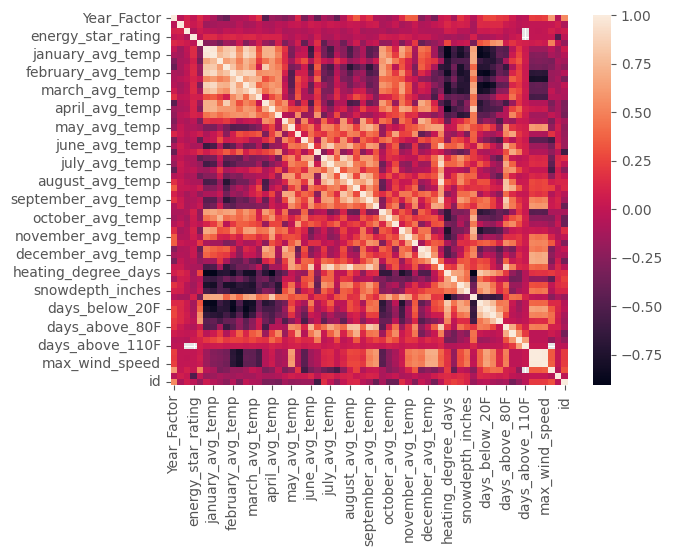

In [32]:
# Correlation amongst numerical columns

x = train.corr()
sns.heatmap(x)

In [33]:
train['year_built'].value_counts()

1927.0    2064
1929.0    1999
1928.0    1979
1930.0    1811
1925.0    1710
          ... 
1878.0       1
1829.0       1
1844.0       1
1871.0       1
1815.0       1
Name: year_built, Length: 180, dtype: int64

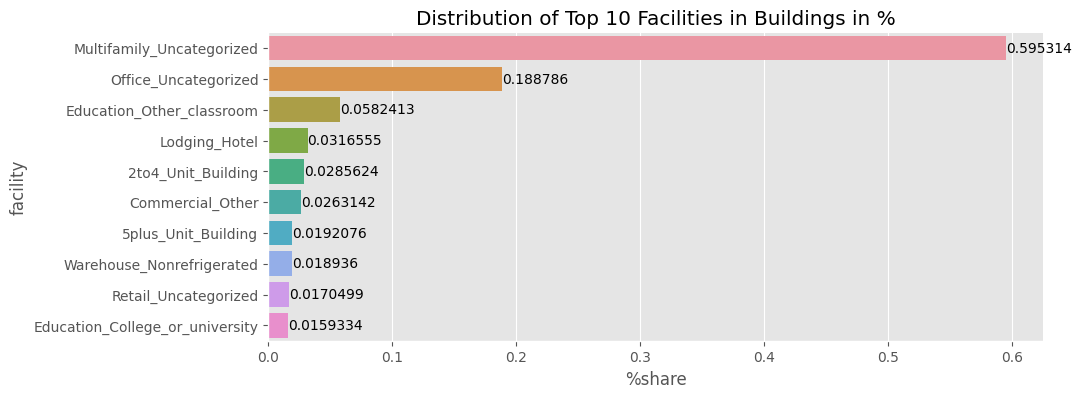

In [34]:
# Distribution of Top 10 Facilities in Buildings in %

dt = pd.DataFrame(train['facility_type'].value_counts().head(10))
dt['facility'] = dt.index
dt.rename(columns = {'facility_type':'count'}, inplace = True)
dt['%share'] = dt['count']/dt['count'].sum()
dt.drop(columns=['count'],inplace=True)
dt.reset_index(drop=True)
plt.figure(figsize=(10,4))
ax = sns.barplot(y='facility',x='%share',data=dt)
for i in ax.containers:
    ax.bar_label(i,)
plt.title("Distribution of Top 10 Facilities in Buildings in %")
plt.show()

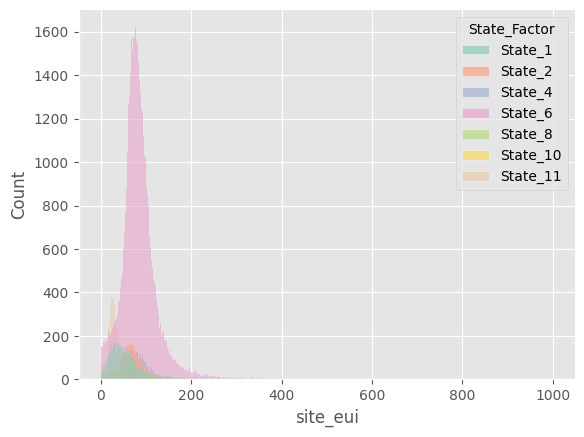

In [35]:
# Commercial Buildings Characterestics which have a high site_eui

sns.histplot(data=train, x='site_eui', hue='State_Factor')
plt.show()

In [36]:
len(train[train['building_class']=='Residential'])

43558

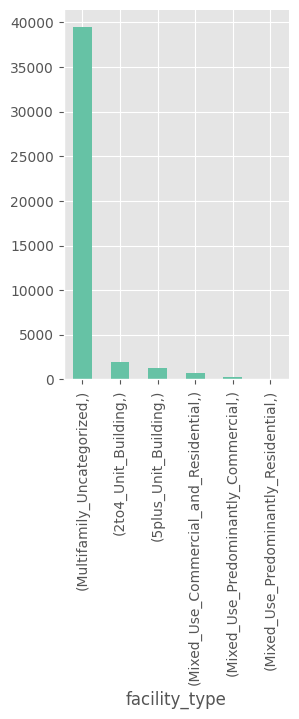

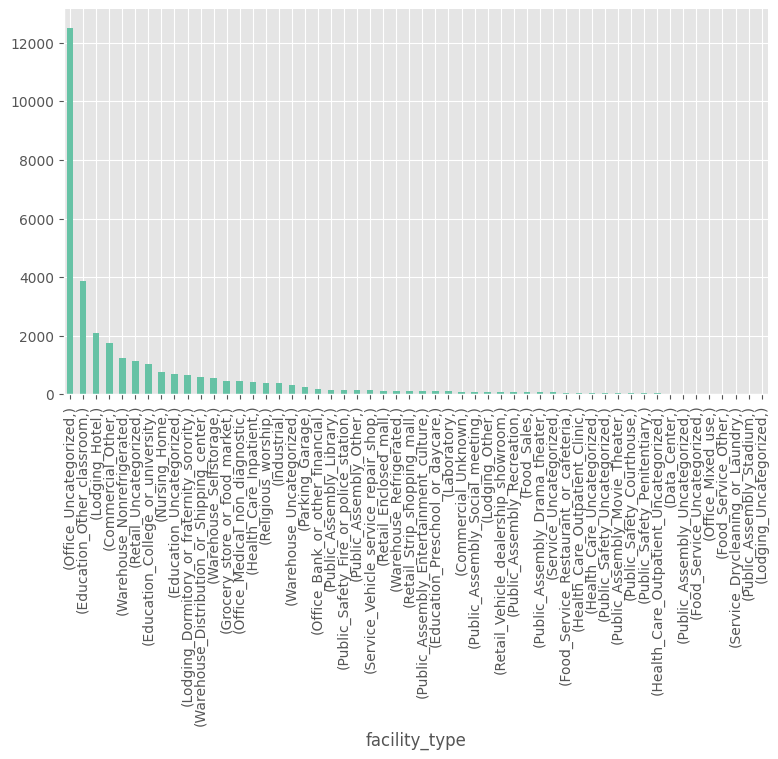

In [37]:
# Building Wise Top 10 Distributions

plt.subplot(1, 2, 1)
train[train['building_class']=='Residential'][['facility_type']].value_counts().plot(kind='bar')

plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 2)
train[train['building_class']=='Commercial'][['facility_type']].value_counts().plot(kind='bar')

plt.show()

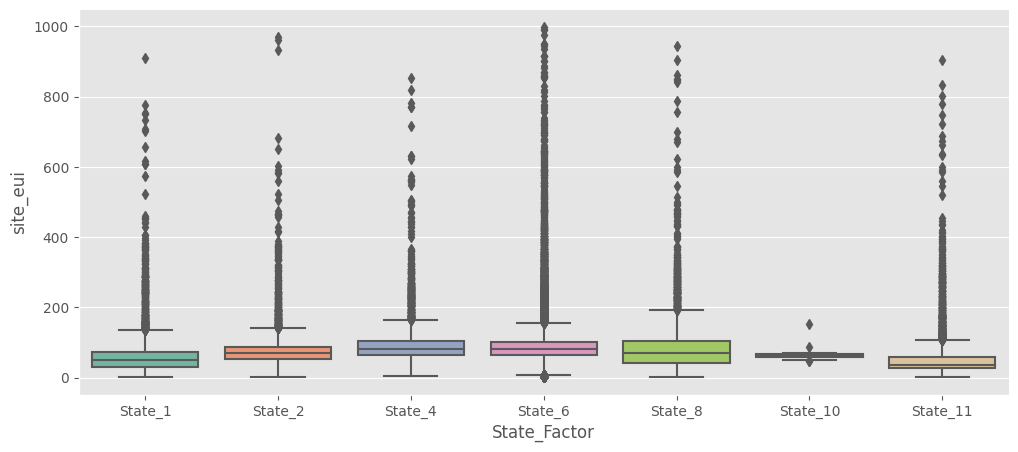

In [38]:
# Distribution of Top 100 Site_EUI wrt to States
plt.figure(figsize=(12, 5))

sns.boxplot(x='State_Factor', y='site_eui', data=train)
plt.show()

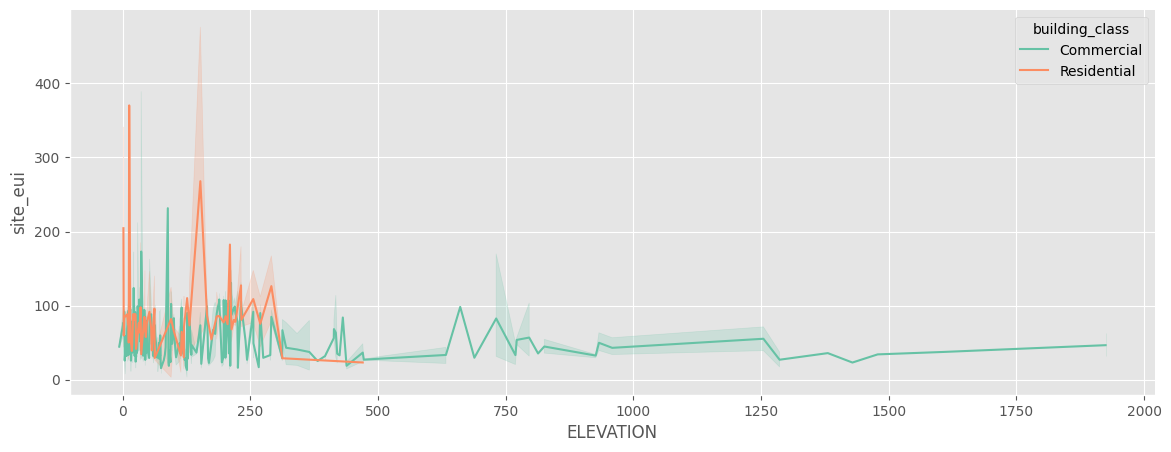

In [39]:
# Distribution of site_eui wrt ELEVATION

plt.figure(figsize=(14, 5))

sns.lineplot(data=train, y='site_eui', x='ELEVATION', hue='building_class')
plt.show()

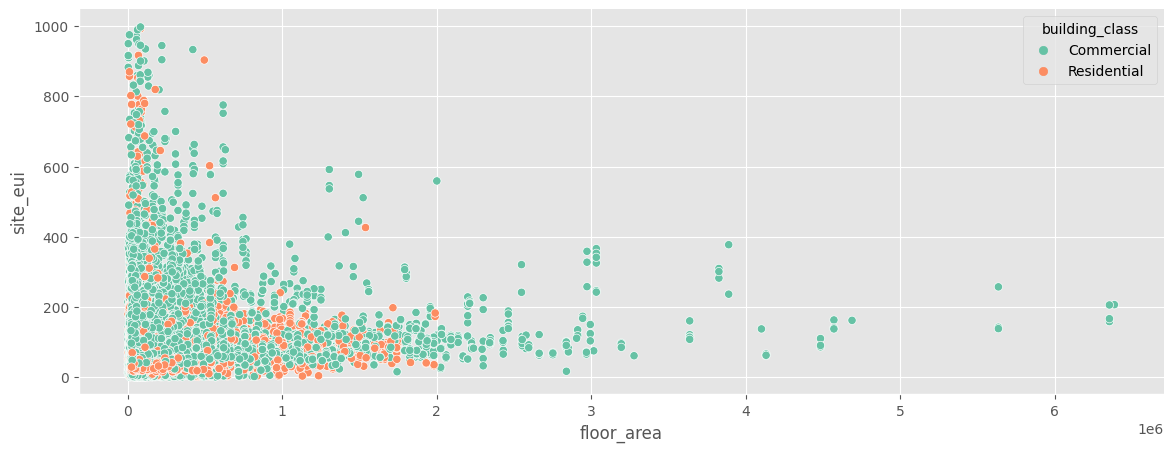

In [40]:
# Correlation between Floor area and building class

plt.figure(figsize=(14, 5))

sns.scatterplot(data=train, x='floor_area', y='site_eui', hue='building_class')
plt.show()

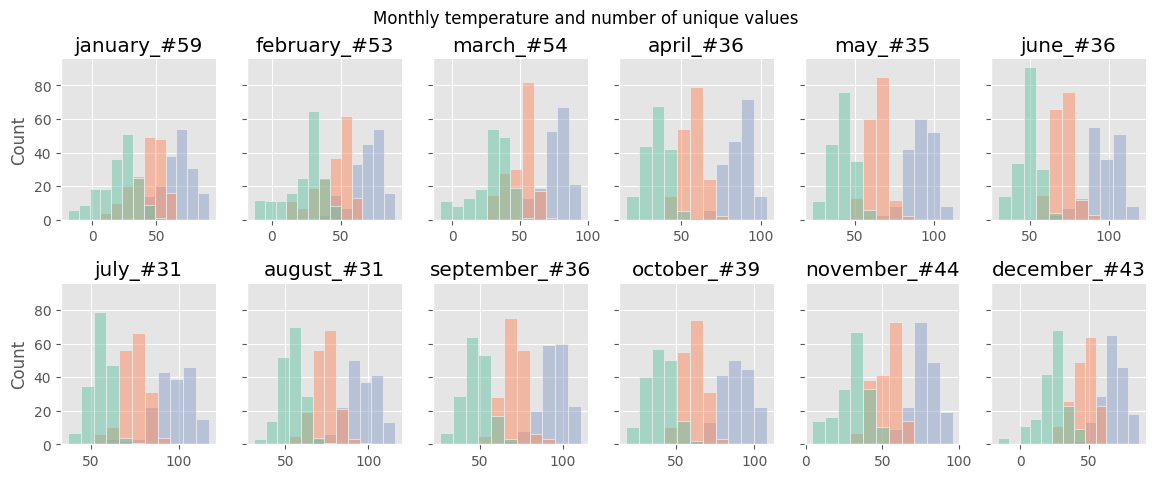

In [41]:
cols = [['january_min_temp', 'january_avg_temp', 'january_max_temp'],
        ['february_min_temp', 'february_avg_temp', 'february_max_temp'],
        ['march_min_temp', 'march_avg_temp', 'march_max_temp'],
        ['april_min_temp','april_avg_temp', 'april_max_temp'],
        ['may_min_temp', 'may_avg_temp','may_max_temp'],
        ['june_min_temp', 'june_avg_temp', 'june_max_temp'],
        ['july_min_temp', 'july_avg_temp', 'july_max_temp'],
        ['august_min_temp','august_avg_temp', 'august_max_temp'],
        ['september_min_temp','september_avg_temp', 'september_max_temp'],
        ['october_min_temp','october_avg_temp', 'october_max_temp'],
        ['november_min_temp','november_avg_temp', 'november_max_temp'],
        ['december_min_temp','december_avg_temp', 'december_max_temp']]

fig, ax = plt.subplots(2, 6, figsize=(14,5), sharey=True)
fig.suptitle("Monthly temperature and number of unique values")

for e, c in enumerate(cols):
    if e<=5:
        sns.histplot(train[c].drop_duplicates(), ax=ax[0,e], legend=False)\
        .set(title=c[0][:c[0].find('_')]+ '_#'+str(len(train[c[0]].unique())))
    else:
        sns.histplot(train[c].drop_duplicates(), ax=ax[1,e-6], legend=False)\
        .set(title=c[0][:c[0].find('_')]+ '_#'+str(len(train[c[0]].unique())))

plt.subplots_adjust(hspace=0.4)

Other weather related numerical columns also have few unique values.

In [42]:
# Combine the dataset

test['site_eui'] = np.nan #63
test['dataset'] = 'test'
train['dataset'] = 'train'

all = pd.concat([train, test], axis=0, ignore_index=True)

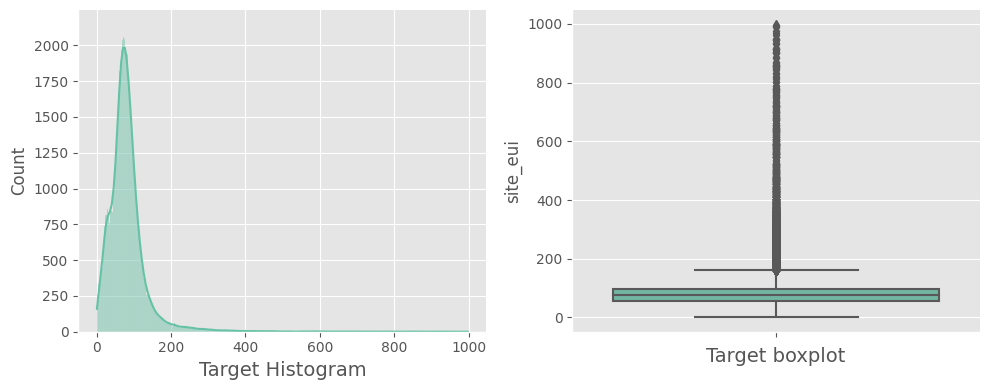

In [43]:
plt.figure(figsize=(10,4))
ax1 = plt.subplot(1,2,1)
cp = sns.histplot(x=all['site_eui'], kde=True, palette='Set2')
ax1.set_xlabel('Target Histogram', fontsize=14)
ax2 = plt.subplot(1,2,2)
sns.boxplot(y=all['site_eui'], palette='Set2')
ax2.set_xlabel('Target boxplot', fontsize=14)
plt.tight_layout();

<Axes: xlabel='building_class', ylabel='site_eui'>

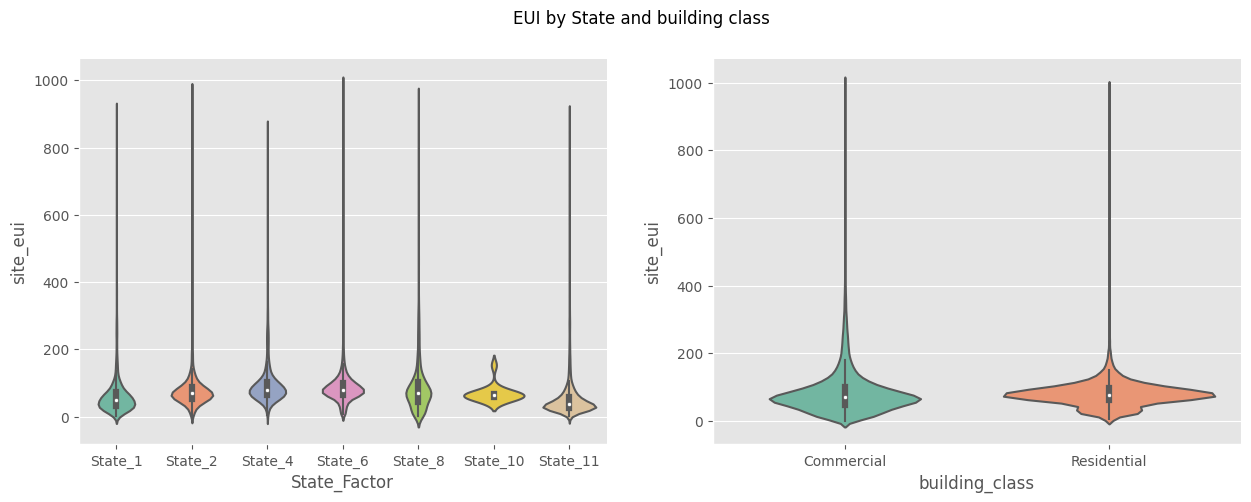

In [44]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
fig.suptitle("EUI by State and building class")

sns.violinplot(data=all, y='site_eui', x='State_Factor', ax=ax[0])
sns.violinplot(data=all, y='site_eui', x='building_class', ax=ax[1])

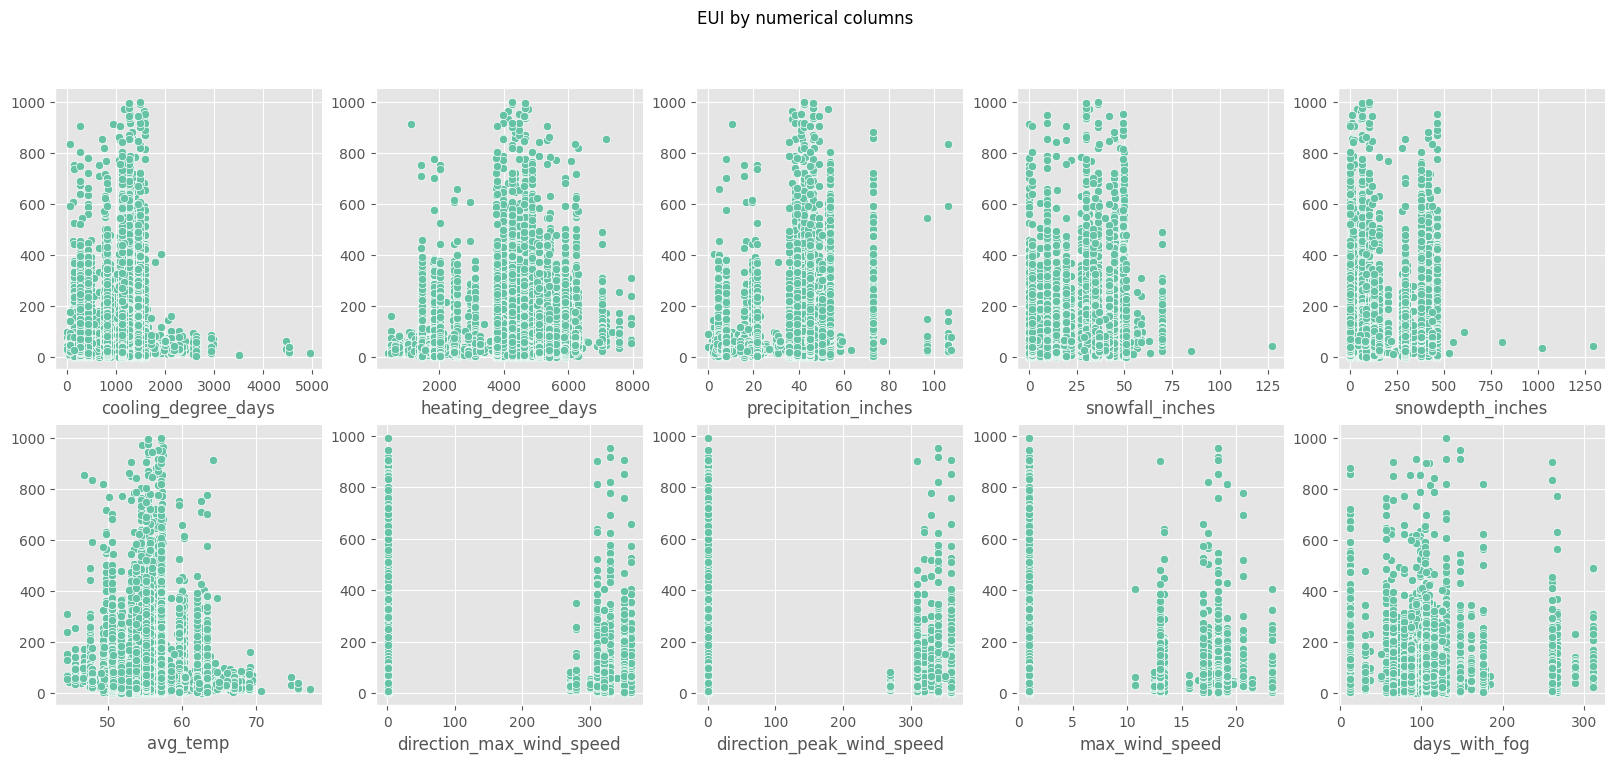

In [45]:
cols=[['cooling_degree_days','heating_degree_days', 'precipitation_inches',
      'snowfall_inches','snowdepth_inches'],
      ['avg_temp',
      'direction_max_wind_speed','direction_peak_wind_speed', 'max_wind_speed',
      'days_with_fog']]

fig, ax = plt.subplots(2,5, figsize=(20,8))
fig.suptitle('EUI by numerical columns')

for e1, l in enumerate(cols):
    for e2, col in enumerate(l):
        sns.scatterplot(data=all, x=col, y='site_eui', ax=ax[e1, e2]).set(ylabel=None)

Text(0.5, 0, '')

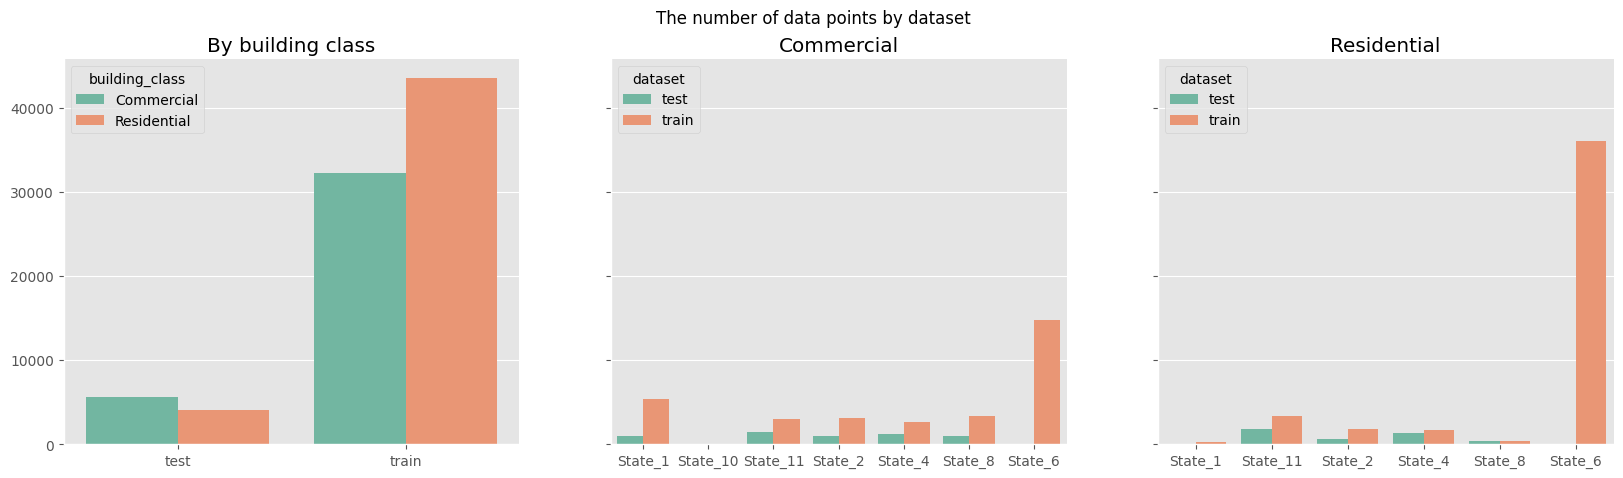

In [46]:
fig, ax = plt.subplots(1,3, figsize=(20,5), sharey=True)
fig.suptitle("The number of data points by dataset")

sns.barplot(x='dataset',
            y='id',
            data=all.groupby(['dataset','building_class']).agg({'id':'count'}).reset_index(),
            hue='building_class',
            ax=ax[0],
            ci=False)

for e, s in enumerate(all['building_class'].unique(),1):
    sns.barplot(x='State_Factor',
                y='id',
                data=all[all['building_class']==s].groupby(['dataset','State_Factor']).agg({'id':'count'}).reset_index(),
                hue='dataset',
                ax=ax[e],
                ci=False)
    ax[e].set_title(s)
    ax[e].set_ylabel("")
    ax[e].set_xlabel("")

ax[0].set_title("By building class")
ax[0].set_ylabel("")
ax[0].set_xlabel("")

All facility types are present in both datasets. Almost 90% of residential `Multifamily_uncategorized` buildings and 50% of `Office_uncategorized` are in `State_6` of the training set. Not quite sure how `State_6` will affect the model learning and prediction.

## Preprocessing

In [47]:
# Removing duplicates by clubbing similar building data

groupby_cols = ['State_Factor','building_class','facility_type','floor_area','year_built']
all = all.sort_values(by=groupby_cols+['Year_Factor']).reset_index(drop=True)

In [48]:
all.loc[:,all.dtypes=='object'].columns

Index(['State_Factor', 'building_class', 'facility_type', 'dataset'], dtype='object')

In [49]:
# Null imputation for categorical values: KNN Imputing

all_one_hot = all.copy()

cats = ['State_Factor', 'facility_type', 'building_class']
for col in cats:
    dummies = pd.get_dummies(all_one_hot[col], dummy_na=False)
    for ohe_col in dummies:
        all_one_hot[f'ohe_{col}_{ohe_col}'] = dummies[ohe_col]

In [50]:
all_one_hot

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,february_max_temp,march_min_temp,march_avg_temp,march_max_temp,april_min_temp,april_avg_temp,april_max_temp,may_min_temp,may_avg_temp,may_max_temp,june_min_temp,june_avg_temp,june_max_temp,july_min_temp,july_avg_temp,july_max_temp,august_min_temp,august_avg_temp,august_max_temp,september_min_temp,september_avg_temp,september_max_temp,...,ohe_facility_type_Multifamily_Uncategorized,ohe_facility_type_Nursing_Home,ohe_facility_type_Office_Bank_or_other_financial,ohe_facility_type_Office_Medical_non_diagnostic,ohe_facility_type_Office_Mixed_use,ohe_facility_type_Office_Uncategorized,ohe_facility_type_Parking_Garage,ohe_facility_type_Public_Assembly_Drama_theater,ohe_facility_type_Public_Assembly_Entertainment_culture,ohe_facility_type_Public_Assembly_Library,ohe_facility_type_Public_Assembly_Movie_Theater,ohe_facility_type_Public_Assembly_Other,ohe_facility_type_Public_Assembly_Recreation,ohe_facility_type_Public_Assembly_Social_meeting,ohe_facility_type_Public_Assembly_Stadium,ohe_facility_type_Public_Assembly_Uncategorized,ohe_facility_type_Public_Safety_Courthouse,ohe_facility_type_Public_Safety_Fire_or_police_station,ohe_facility_type_Public_Safety_Penitentiary,ohe_facility_type_Public_Safety_Uncategorized,ohe_facility_type_Religious_worship,ohe_facility_type_Retail_Enclosed_mall,ohe_facility_type_Retail_Strip_shopping_mall,ohe_facility_type_Retail_Uncategorized,ohe_facility_type_Retail_Vehicle_dealership_showroom,ohe_facility_type_Service_Drycleaning_or_Laundry,ohe_facility_type_Service_Uncategorized,ohe_facility_type_Service_Vehicle_service_repair_shop,ohe_facility_type_Warehouse_Distribution_or_Shipping_center,ohe_facility_type_Warehouse_Nonrefrigerated,ohe_facility_type_Warehouse_Refrigerated,ohe_facility_type_Warehouse_Selfstorage,ohe_facility_type_Warehouse_Uncategorized,ohe_building_class_Commercial,ohe_building_class_Residential
0,3,State_1,Commercial,Commercial_Other,10149.0,1931.0,NaN,45.7,26,44.516129,64,30,49.392857,69,37,55.967742,77,40,61.783333,90,45,65.129032,91,52,70.016667,104,52,71.387097,102,54,71.322581,97,47,69.133333,98,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,4,State_1,Commercial,Commercial_Other,10149.0,1931.0,NaN,120.4,41,55.096774,73,42,54.875000,71,47,59.032258,76,47,60.100000,90,51,63.483871,92,52,64.250000,87,53,66.903226,90,57,67.016129,80,56,68.383333,83,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,5,State_1,Commercial,Commercial_Other,10149.0,1931.0,NaN,59.1,29,51.387097,77,36,56.803571,75,40,61.435484,85,41,60.966667,91,45,62.887097,90,55,72.983333,106,60,74.516129,103,58,74.774194,104,53,73.583333,105,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,7,State_1,Commercial,Commercial_Other,10149.0,1931.0,NaN,59.1,38,50.596774,64,40,54.482143,66,42,56.935484,77,45,58.450000,78,49,60.903226,87,51,63.150000,97,53,64.258065,85,53,65.854839,88,54,69.766667,104,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,3,State_1,Commercial,Commercial_Other,10755.0,1937.0,NaN,9.1,22,44.790323,65,25,47.892857,71,32,53.112903,79,34,58.866667,87,35,62.096774,91,44,66.283333,99,48,65.693548,91,45,67.080645,92,42,65.950000,96,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85457,7,State_8,Residential,Multifamily_Uncategorized,900000.0,1960.0,90.0,130.8,2,33.435484,61,16,37.660714,73,8,35.935484,69,28,54.800000,85,38,59.096774,92,40,68.689655,91,53,74.677419,91,52,70.564516,89,40,66.250000,91,...,1,0,0,

In [51]:
knn_imputing = False
target='site_eui'

if knn_imputing:
    imputer = KNNImputer(n_neighbors=7)
    tmp = all[['State_Factor', 'building_class', 'facility_type', 'dataset', target]]
    df = all.drop(tmp.columns, axis=1)
    df1 = pd.DataFrame(imputer.fit_transform(df), columns = df.columns)
    tmp.to_csv('imputer_tmp.csv', index=False)
    df1.to_csv('imputer_df1.csv', index=False)
    joblib.dump(imputer, 'knn_imputer.pkl')

else:
    df1 = pd.read_csv('imputer_df1.csv')
    tmp = all[['State_Factor', 'building_class', 'facility_type', 'dataset', target]]
    all = all.drop(tmp.columns, axis=1)
    for col in tmp.columns:
        all[col]=tmp[col]
    for col in df1.columns:
        all[col] = df1[col]

In [52]:
all.shape

(85462, 134)

In [57]:
all.columns.T

Index(['Year_Factor', 'floor_area', 'year_built', 'energy_star_rating',
       'ELEVATION', 'january_min_temp', 'january_avg_temp', 'january_max_temp',
       'february_min_temp', 'february_avg_temp',
       ...
       'ohe_facility_type_Service_Drycleaning_or_Laundry',
       'ohe_facility_type_Service_Uncategorized',
       'ohe_facility_type_Service_Vehicle_service_repair_shop',
       'ohe_facility_type_Warehouse_Distribution_or_Shipping_center',
       'ohe_facility_type_Warehouse_Nonrefrigerated',
       'ohe_facility_type_Warehouse_Refrigerated',
       'ohe_facility_type_Warehouse_Selfstorage',
       'ohe_facility_type_Warehouse_Uncategorized',
       'ohe_building_class_Commercial', 'ohe_building_class_Residential'],
      dtype='object', length=134)

In [55]:
all.head()

,Year_Factor,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,february_max_temp,march_min_temp,march_avg_temp,march_max_temp,april_min_temp,april_avg_temp,april_max_temp,may_min_temp,may_avg_temp,may_max_temp,june_min_temp,june_avg_temp,june_max_temp,july_min_temp,july_avg_temp,july_max_temp,august_min_temp,august_avg_temp,august_max_temp,september_min_temp,september_avg_temp,september_max_temp,october_min_temp,october_avg_temp,october_max_temp,...,ohe_facility_type_Multifamily_Uncategorized,ohe_facility_type_Nursing_Home,ohe_facility_type_Office_Bank_or_other_financial,ohe_facility_type_Office_Medical_non_diagnostic,ohe_facility_type_Office_Mixed_use,ohe_facility_type_Office_Uncategorized,ohe_facility_type_Parking_Garage,ohe_facility_type_Public_Assembly_Drama_theater,ohe_facility_type_Public_Assembly_Entertainment_culture,ohe_facility_type_Public_Assembly_Library,ohe_facility_type_Public_Assembly_Movie_Theater,ohe_facility_type_Public_Assembly_Other,ohe_facility_type_Public_Assembly_Recreation,ohe_facility_type_Public_Assembly_Social_meeting,ohe_facility_type_Public_Assembly_Stadium,ohe_facility_type_Public_Assembly_Uncategorized,ohe_facility_type_Public_Safety_Courthouse,ohe_facility_type_Public_Safety_Fire_or_police_station,ohe_facility_type_Public_Safety_Penitentiary,ohe_facility_type_Public_Safety_Uncategorized,ohe_facility_type_Religious_worship,ohe_facility_type_Retail_Enclosed_mall,ohe_facility_type_Retail_Strip_shopping_mall,ohe_facility_type_Retail_Uncategorized,ohe_facility_type_Retail_Vehicle_dealership_showroom,ohe_facility_type_Service_Drycleaning_or_Laundry,ohe_facility_type_Service_Uncategorized,ohe_facility_type_Service_Vehicle_service_repair_shop,ohe_facility_type_Warehouse_Distribution_or_Shipping_center,ohe_facility_type_Warehouse_Nonrefrigerated,ohe_facility_type_Warehouse_Refrigerated,ohe_facility_type_Warehouse_Selfstorage,ohe_facility_type_Warehouse_Uncategorized,ohe_building_class_Commercial,ohe_building_class_Residential
0,3.0,10149.0,1931.0,38.428571,45.7,26.0,44.516129,64.0,30.0,49.392857,69.0,37.0,55.967742,77.0,40.0,61.783333,90.0,45.0,65.129032,91.0,52.0,70.016667,104.0,52.0,71.387097,102.0,54.0,71.322581,97.0,47.0,69.133333,98.0,43.0,61.000000,84.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,4.0,10149.0,1931.0,43.571429,120.4,41.0,55.096774,73.0,42.0,54.875000,71.0,47.0,59.032258,76.0,47.0,60.100000,90.0,51.0,63.483871,92.0,52.0,64.250000,87.0,53.0,66.903226,90.0,57.0,67.016129,80.0,56.0,68.383333,83.0,55.0,68.661290,95.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,5.0,10149.0,1931.0,37.571429,59.1,29.0,51.387097,77.0,36.0,56.803571,75.0,40.0,61.435484,85.0,41.0,60.966667,91.0,45.0,62.887097,90.0,55.0,72.983333,106.0,60.0,74.516129,103.0,58.0,74.774194,104.0,53.0,73.583333,105.0,49.0,69.580645,96.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,7.0,10149.0,1931.0,60.285714,59.1,38.0,50.596774,64.0,40.0,54.482143,66.0,42.0,56.935484,77.0,45.0,58.450000,78.0,49.0,60.903226,87.0,51.0,63.150000,97.0,53.0,64.258065,85.0,53.0,65.854839,88.0,54.0,69.766667,104.0,48.0,64.193548,91.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,3.0,10755.0,1937.0,45.571429,9.1,22.0,44.790323,65.0,25.0,47.892857,71.0,32.0,53.112903,79.0,34.0,58.866667,87.0,35.0,62.096774,91.0,44.0,66.283333,99.0,48.0,65.693548,91.0,45.0,67.080645,92.0,42.0,65.950000,96.0,35.0,56.967742,85.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [54]:
all_te = all.copy()

cats = ['State_Factor', 'building_class', 'facility_type']
for col in cats:
    encoder = TargetEncoder()
    all_te[f'te_{col}'] = encoder.fit_transform(all_te[col], all_te[target])

In [58]:
all_te.columns

Index(['Year_Factor', 'floor_area', 'year_built', 'energy_star_rating',
       'ELEVATION', 'january_min_temp', 'january_avg_temp', 'january_max_temp',
       'february_min_temp', 'february_avg_temp',
       ...
       'ohe_facility_type_Warehouse_Distribution_or_Shipping_center',
       'ohe_facility_type_Warehouse_Nonrefrigerated',
       'ohe_facility_type_Warehouse_Refrigerated',
       'ohe_facility_type_Warehouse_Selfstorage',
       'ohe_facility_type_Warehouse_Uncategorized',
       'ohe_building_class_Commercial', 'ohe_building_class_Residential',
       'te_State_Factor', 'te_building_class', 'te_facility_type'],
      dtype='object', length=137)

In [41]:
all_te.shape

(85462, 137)

## Feature Engineering

**Weather Based Features**

We will extract new weather statistics from the building location weather features.

In [59]:
# extract new weather statistics from the building location weather features
temp = [col for col in all_te.columns if 'temp' in col]

all_te['min_temp'] = all_te[temp].min(axis=1)
all_te['max_temp'] = all_te[temp].max(axis=1)
all_te['avg_temp'] = all_te[temp].mean(axis=1)
all_te['std_temp'] = all_te[temp].std(axis=1)
all_te['skew_temp'] = all_te[temp].skew(axis=1)


# by seasons
temp = pd.Series([col for col in all_te.columns if 'temp' in col])

winter_temp = temp[temp.apply(lambda x: ('january' in x or 'february' in x or 'december' in x))].values
spring_temp = temp[temp.apply(lambda x: ('march' in x or 'april' in x or 'may' in x))].values
summer_temp = temp[temp.apply(lambda x: ('june' in x or 'july' in x or 'august' in x))].values
autumn_temp = temp[temp.apply(lambda x: ('september' in x or 'october' in x or 'november' in x))].values


### winter
all_te['min_winter_temp'] = all_te[winter_temp].min(axis=1)
all_te['max_winter_temp'] = all_te[winter_temp].max(axis=1)
all_te['avg_winter_temp'] = all_te[winter_temp].mean(axis=1)
all_te['std_winter_temp'] = all_te[winter_temp].std(axis=1)
all_te['skew_winter_temp'] = all_te[winter_temp].skew(axis=1)
### spring
all_te['min_spring_temp'] = all_te[spring_temp].min(axis=1)
all_te['max_spring_temp'] = all_te[spring_temp].max(axis=1)
all_te['avg_spring_temp'] = all_te[spring_temp].mean(axis=1)
all_te['std_spring_temp'] = all_te[spring_temp].std(axis=1)
all_te['skew_spring_temp'] = all_te[spring_temp].skew(axis=1)
### summer
all_te['min_summer_temp'] = all_te[summer_temp].min(axis=1)
all_te['max_summer_temp'] = all_te[summer_temp].max(axis=1)
all_te['avg_summer_temp'] = all_te[summer_temp].mean(axis=1)
all_te['std_summer_temp'] = all_te[summer_temp].max(axis=1)
all_te['skew_summer_temp'] = all_te[summer_temp].max(axis=1)
## autumn
all_te['min_autumn_temp'] = all_te[autumn_temp].min(axis=1)
all_te['max_autumn_temp'] = all_te[autumn_temp].max(axis=1)
all_te['avg_autumn_temp'] = all_te[autumn_temp].mean(axis=1)
all_te['std_autumn_temp'] = all_te[autumn_temp].std(axis=1)
all_te['skew_autumn_temp'] = all_te[autumn_temp].skew(axis=1)

In [60]:
all_te['month_cooling_degree_days'] = all_te['cooling_degree_days']/12
all_te['month_heating_degree_days'] = all_te['heating_degree_days']/12

In [61]:
all_te[temp]

,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,february_max_temp,march_min_temp,march_avg_temp,march_max_temp,april_min_temp,april_avg_temp,april_max_temp,may_min_temp,may_avg_temp,may_max_temp,june_min_temp,june_avg_temp,june_max_temp,july_min_temp,july_avg_temp,july_max_temp,august_min_temp,august_avg_temp,august_max_temp,september_min_temp,september_avg_temp,september_max_temp,october_min_temp,october_avg_temp,october_max_temp,november_min_temp,november_avg_temp,november_max_temp,december_min_temp,december_avg_temp,december_max_temp,avg_temp,min_temp,max_temp,std_temp,skew_temp
0,26.0,44.516129,64.0,30.0,49.392857,69.0,37.0,55.967742,77.0,40.0,61.783333,90.0,45.0,65.129032,91.0,52.0,70.016667,104.0,52.0,71.387097,102.0,54.0,71.322581,97.0,47.0,69.133333,98.0,43.0,61.000000,84.0,36.0,55.116667,77.0,24.0,45.387097,68.0,61.816451,24.0,104.0,21.308416,0.281828
1,41.0,55.096774,73.0,42.0,54.875000,71.0,47.0,59.032258,76.0,47.0,60.100000,90.0,51.0,63.483871,92.0,52.0,64.250000,87.0,53.0,66.903226,90.0,57.0,67.016129,80.0,56.0,68.383333,83.0,55.0,68.661290,95.0,46.0,59.650000,76.0,41.0,56.790323,68.0,64.197549,41.0,95.0,14.980311,0.428700
2,29.0,51.387097,77.0,36.0,56.803571,75.0,40.0,61.435484,85.0,41.0,60.966667,91.0,45.0,62.887097,90.0,55.0,72.983333,106.0,60.0,74.516129,103.0,58.0,74.774194,104.0,53.0,73.583333,105.0,49.0,69.580645,96.0,29.0,52.866667,75.0,28.0,48.580645,68.0,65.453067,28.0,106.0,21.906277,0.212369
3,38.0,50.596774,64.0,40.0,54.482143,66.0,42.0,56.935484,77.0,45.0,58.450000,78.0,49.0,60.903226,87.0,51.0,63.150000,97.0,53.0,64.258065,85.0,53.0,65.854839,88.0,54.0,69.766667,104.0,48.0,64.193548,91.0,43.0,58.050000,69.0,38.0,51.887097,66.0,62.281685,38.0,104.0,16.708230,0.725826
4,22.0,44.790323,65.0,25.0,47.892857,71.0,32.0,53.112903,79.0,34.0,58.866667,87.0,35.0,62.096774,91.0,44.0,66.283333,99.0,48.0,65.693548,91.0,45.0,67.080645,92.0,42.0,65.950000,96.0,35.0,56.967742,85.0,31.0,52.516667,76.0,16.0,43.338710,68.0,58.126280,16.0,99.0,22.272150,0.113857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85457,2.0,33.435484,61.0,16.0,37.660714,73.0,8.0,35.935484,69.0,28.0,54.800000,85.0,38.0,59.096774,92.0,40.0,68.689655,91.0,53.0,74.677419,91.0,52.0,70.564516,89.0,40.0,66.250000,91.0,33.0,58.129032,83.0,17.0,41.583333,74.0,3.0,29.933333,57.0,53.227074,2.0,92.0,26.069571,-0.249731
85458,8.0,29.827586,62.0,4.0,33.896552,62.0,24.0,45.967742,79.0,18.0,49.931034,81.0,37.0,59.161290,89.0,45.0,70.465517,90.0,57.0,77.083333,96.0,54.0,75.725806,95.0,40.0,68.200000,96.0,24.0,55.258065,85.0,20.0,44.316667,71.0,12.0,35.129032,58.0,54.210864,4.0,96.0,26.198215,-0.136906
85459,2.0,33.435484,61.0,16.0,37.660714,73.0,8.0,35.935484,69.0,28.0,54.800000,85.0,38.0,59.096774,92.0,40.0,68.689655,91.0,53.0,74.677419,91.0,52.0,70.564516,89.0,40.0,66.250000,91.0,33.0,58.129032,83.0,17.0,41.583333,74.0,3.0,29.933333,57.0,53.227074,2.0,92.0,26.069571,-0.249731
85460,8.0,29.827586,62.0,4.0,33.896552,62.0,24.0,45.967742,79.0,18.0,49.931034,81.0,37.0,59.161290,89.0,45.0,70.465517,90.0,57.0,77.083333,96.0,54.0,75.725806,95.0,40.0,68.200000,96.0,24.0,55.258065,85.0,20.0,44.316667,71.0,12.0,35.129032,58.0,54.210864,4.0,96.0,26.198215,-0.136906


In [62]:
all_te['cooling_degree_days']

0         826.0
1         497.0
2        1319.0
3         342.0
4         303.0
          ...  
85457     866.0
85458    1114.0
85459     866.0
85460    1114.0
85461     866.0
Name: cooling_degree_days, Length: 85462, dtype: float64

In [63]:
all_te[['min_winter_temp', 'max_winter_temp', 'avg_winter_temp', 'std_winter_temp', 'skew_winter_temp',
        'min_spring_temp', 'max_spring_temp', 'avg_spring_temp', 'std_spring_temp', 'skew_spring_temp',
        'min_summer_temp', 'max_summer_temp', 'avg_summer_temp', 'std_summer_temp', 'skew_summer_temp',
        'min_autumn_temp', 'max_autumn_temp', 'avg_autumn_temp', 'std_autumn_temp', 'skew_autumn_temp']]

,min_winter_temp,max_winter_temp,avg_winter_temp,std_winter_temp,skew_winter_temp,min_spring_temp,max_spring_temp,avg_spring_temp,std_spring_temp,skew_spring_temp,min_summer_temp,max_summer_temp,avg_summer_temp,std_summer_temp,skew_summer_temp,min_autumn_temp,max_autumn_temp,avg_autumn_temp,std_autumn_temp,skew_autumn_temp
0,24.0,69.0,46.699565,17.630529,0.021018,37.0,91.0,62.542234,20.284168,0.250054,52.0,104.0,74.858483,104.0,104.0,36.0,98.0,63.361111,20.462133,0.360253
1,41.0,73.0,55.862455,12.779553,0.081583,47.0,92.0,65.068459,17.251378,0.670141,52.0,90.0,68.574373,90.0,90.0,46.0,95.0,67.521625,15.342943,0.494753
2,28.0,77.0,52.196813,18.727631,0.005259,40.0,91.0,64.143250,20.398627,0.230872,55.0,106.0,78.697073,106.0,106.0,29.0,105.0,67.003405,23.881873,0.162329
3,38.0,66.0,52.107335,11.619161,-0.034349,42.0,87.0,61.587634,15.818993,0.417654,51.0,97.0,68.918100,97.0,97.0,43.0,104.0,66.778913,19.843743,0.883927
4,16.0,71.0,44.780210,20.572244,-0.084189,32.0,91.0,59.119594,22.864101,0.160184,44.0,99.0,68.673059,99.0,99.0,31.0,96.0,60.048268,22.548770,0.276234
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85457,2.0,73.0,34.781059,25.280345,0.107184,8.0,92.0,52.203584,27.390463,-0.033897,40.0,91.0,69.992399,91.0,91.0,17.0,91.0,55.995818,24.752362,-0.095805
85458,4.0,62.0,33.872574,22.974302,0.053637,18.0,89.0,53.673341,25.423297,0.041405,45.0,96.0,73.363851,96.0,96.0,20.0,96.0,55.974970,26.286606,0.078569
85459,2.0,73.0,34.781059,25.280345,0.107184,8.0,92.0,52.203584,27.390463,-0.033897,40.0,91.0,69.992399,91.0,91.0,17.0,91.0,55.995818,24.752362,-0.095805
85460,4.0,62.0,33.872574,22.974302,0.053637,18.0,89.0,53.673341,25.423297,0.041405,45.0,96.0,73.363851,96.0,96.0,20.0,96.0,55.974970,26.286606,0.078569


**Building Based Features**

we will extract building statistics

In [64]:
# total area
all_te['building_area'] = all_te['floor_area'] * all_te['ELEVATION']

# rating energy by floor
all_te['floor_energy_star_rating'] = all_te['energy_star_rating']/all_te['ELEVATION']

In [65]:
all_te[["floor_area", "ELEVATION", "energy_star_rating", "floor_energy_star_rating", "building_area"]]

,floor_area,ELEVATION,energy_star_rating,floor_energy_star_rating,building_area
0,10149.0,45.7,38.428571,0.840888,463809.3
1,10149.0,120.4,43.571429,0.361889,1221939.6
2,10149.0,59.1,37.571429,0.635726,599805.9
3,10149.0,59.1,60.285714,1.020063,599805.9
4,10755.0,9.1,45.571429,5.007849,97870.5
...,...,...,...,...,...
85457,900000.0,130.8,90.000000,0.688073,117720000.0
85458,1179072.0,3.0,96.000000,32.000000,3537216.0
85459,1179072.0,130.8,92.000000,0.703364,154222617.6
85460,1195034.0,3.0,75.000000,25.000000,3585102.0


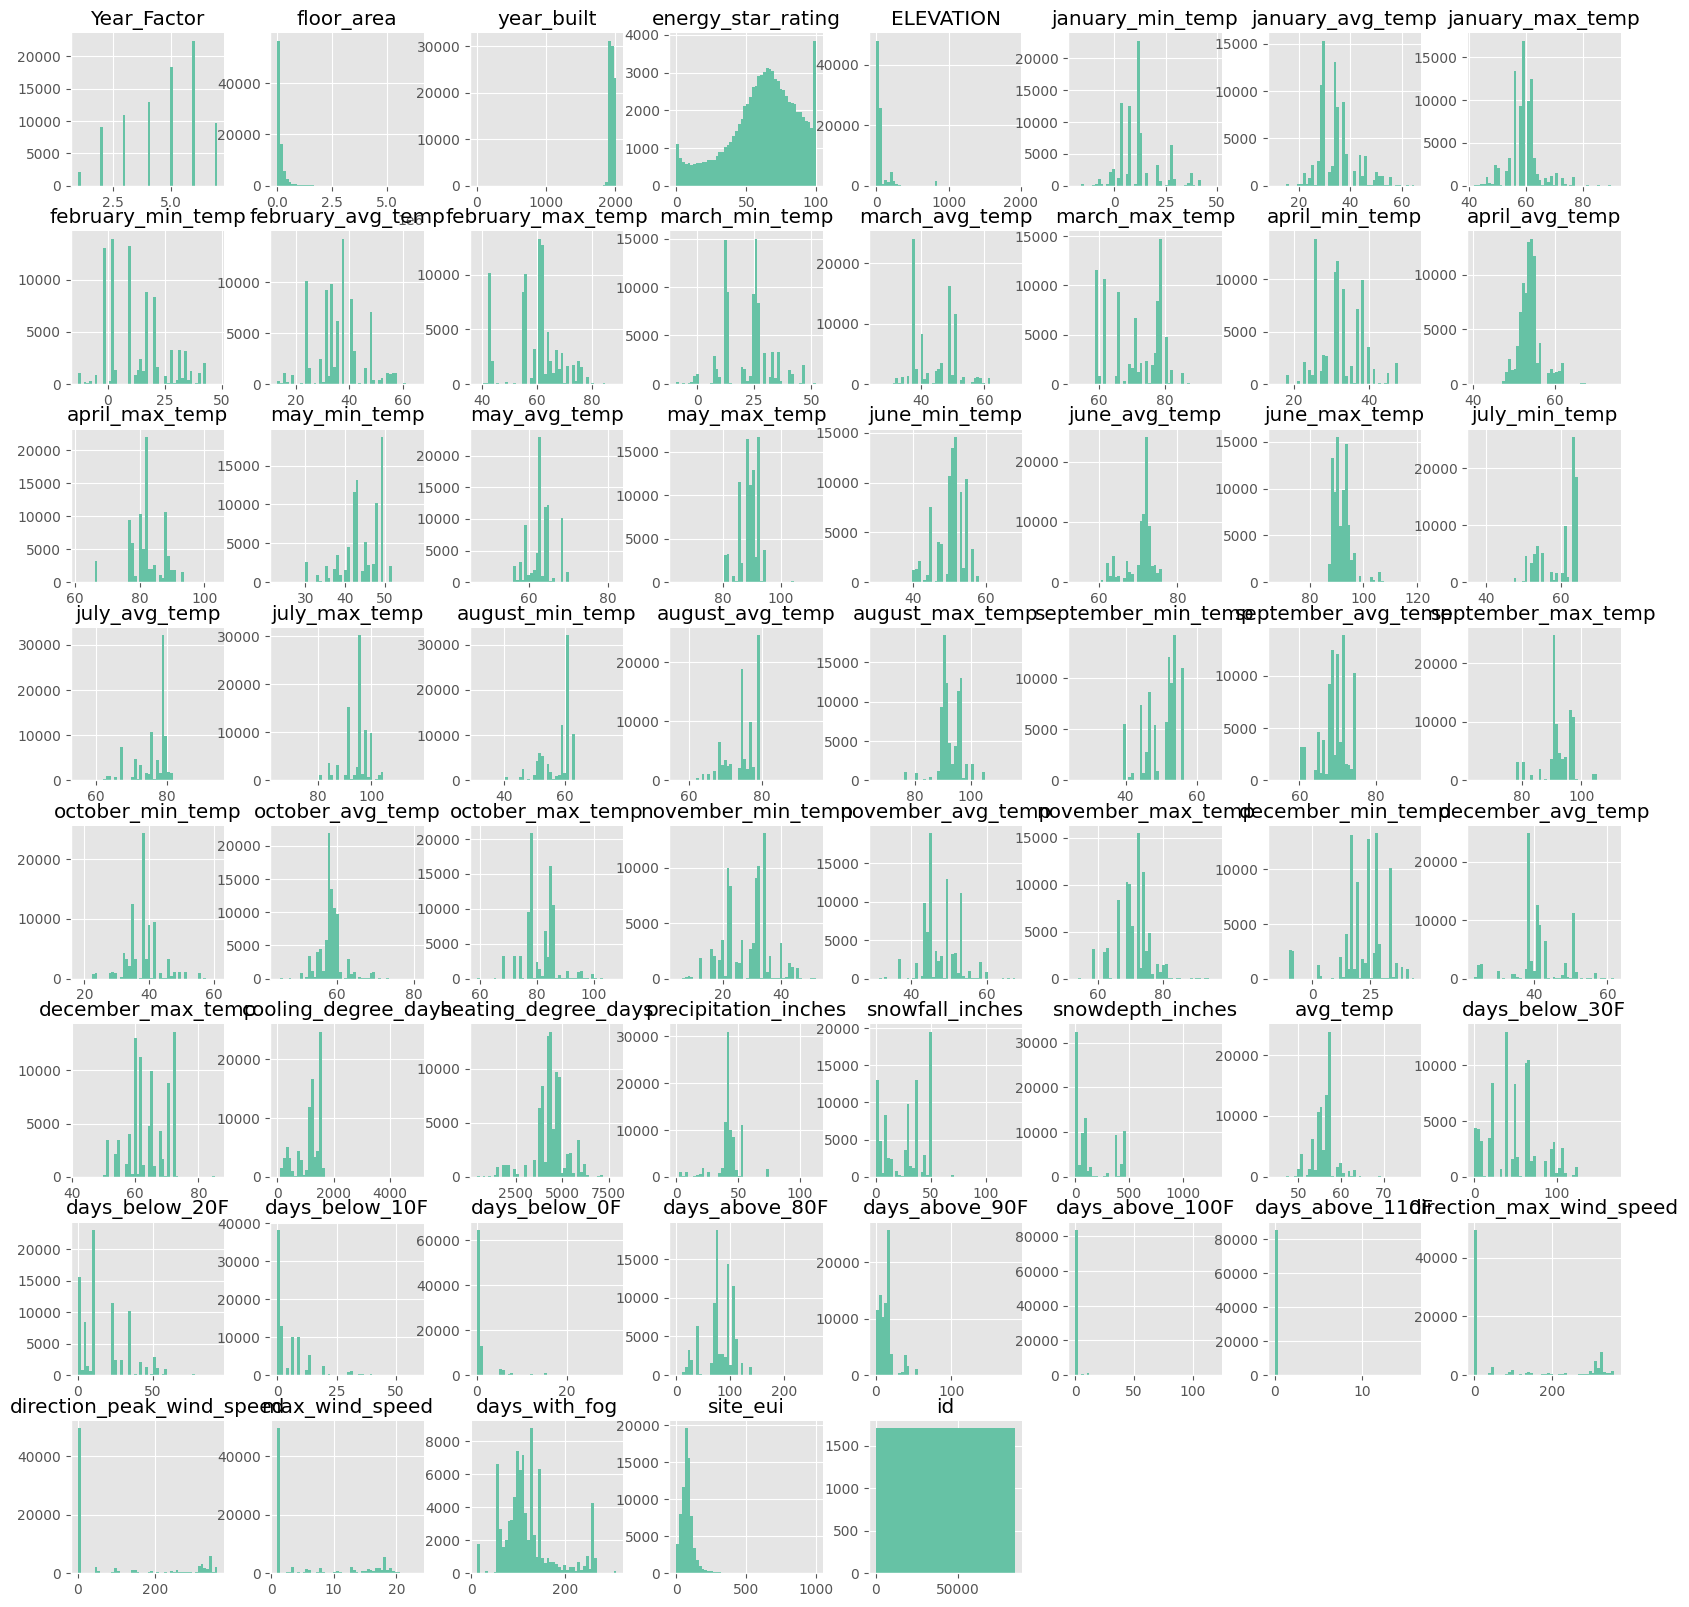

In [66]:
nums = train.loc[:, train.dtypes != 'object'].columns
all[nums].hist(bins=50, figsize=(20,20))
plt.show();

In [67]:
all_te[nums].skew().sort_values(key=abs, ascending=False)[:5]

days_above_110F    89.873857
days_above_100F    24.615438
year_built        -11.716545
floor_area          6.701786
ELEVATION           5.140444
dtype: float64

In [68]:
# Binarize very skewed variables

skewed = ['days_above_110F', 'days_above_100F']

for var in skewed:

    # map the variable values into 0 and 1
    all_te[var] = np.where(all_te[var]==0, 0, 1)

In [69]:
all_te.shape

(85462, 165)

## Saving Feature Dataset

In [70]:
saved = False
if saved:
    !pip install pickle5 --quiet
    import pickle5 as pickle
    data_path = 'feature_transformed_set_TEonly.pkl'
    with open(data_path, "rb") as fh:
        df = pickle.load(fh)
else:
    all.to_pickle('feature_transformed_set_TEonly.pkl')

In [71]:
all_te.shape

(85462, 165)

In [72]:
all_te.head()

,Year_Factor,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,february_max_temp,march_min_temp,march_avg_temp,march_max_temp,april_min_temp,april_avg_temp,april_max_temp,may_min_temp,may_avg_temp,may_max_temp,june_min_temp,june_avg_temp,june_max_temp,july_min_temp,july_avg_temp,july_max_temp,august_min_temp,august_avg_temp,august_max_temp,september_min_temp,september_avg_temp,september_max_temp,october_min_temp,october_avg_temp,october_max_temp,...,ohe_facility_type_Warehouse_Selfstorage,ohe_facility_type_Warehouse_Uncategorized,ohe_building_class_Commercial,ohe_building_class_Residential,te_State_Factor,te_building_class,te_facility_type,min_temp,max_temp,std_temp,skew_temp,min_winter_temp,max_winter_temp,avg_winter_temp,std_winter_temp,skew_winter_temp,min_spring_temp,max_spring_temp,avg_spring_temp,std_spring_temp,skew_spring_temp,min_summer_temp,max_summer_temp,avg_summer_temp,std_summer_temp,skew_summer_temp,min_autumn_temp,max_autumn_temp,avg_autumn_temp,std_autumn_temp,skew_autumn_temp,month_cooling_degree_days,month_heating_degree_days,building_area,floor_energy_star_rating
0,3.0,10149.0,1931.0,38.428571,45.7,26.0,44.516129,64.0,30.0,49.392857,69.0,37.0,55.967742,77.0,40.0,61.783333,90.0,45.0,65.129032,91.0,52.0,70.016667,104.0,52.0,71.387097,102.0,54.0,71.322581,97.0,47.0,69.133333,98.0,43.0,61.000000,84.0,...,0.0,0.0,1.0,0.0,62.196194,85.755239,92.642037,24.0,104.0,21.308416,0.281828,24.0,69.0,46.699565,17.630529,0.021018,37.0,91.0,62.542234,20.284168,0.250054,52.0,104.0,74.858483,104.0,104.0,36.0,98.0,63.361111,20.462133,0.360253,68.833333,211.833333,463809.3,0.840888
1,4.0,10149.0,1931.0,43.571429,120.4,41.0,55.096774,73.0,42.0,54.875000,71.0,47.0,59.032258,76.0,47.0,60.100000,90.0,51.0,63.483871,92.0,52.0,64.250000,87.0,53.0,66.903226,90.0,57.0,67.016129,80.0,56.0,68.383333,83.0,55.0,68.661290,95.0,...,0.0,0.0,1.0,0.0,62.196194,85.755239,92.642037,41.0,95.0,14.980311,0.428700,41.0,73.0,55.862455,12.779553,0.081583,47.0,92.0,65.068459,17.251378,0.670141,52.0,90.0,68.574373,90.0,90.0,46.0,95.0,67.521625,15.342943,0.494753,41.416667,123.083333,1221939.6,0.361889
2,5.0,10149.0,1931.0,37.571429,59.1,29.0,51.387097,77.0,36.0,56.803571,75.0,40.0,61.435484,85.0,41.0,60.966667,91.0,45.0,62.887097,90.0,55.0,72.983333,106.0,60.0,74.516129,103.0,58.0,74.774194,104.0,53.0,73.583333,105.0,49.0,69.580645,96.0,...,0.0,0.0,1.0,0.0,62.196194,85.755239,92.642037,28.0,106.0,21.906277,0.212369,28.0,77.0,52.196813,18.727631,0.005259,40.0,91.0,64.143250,20.398627,0.230872,55.0,106.0,78.697073,106.0,106.0,29.0,105.0,67.003405,23.881873,0.162329,109.916667,151.916667,599805.9,0.635726
3,7.0,10149.0,1931.0,60.285714,59.1,38.0,50.596774,64.0,40.0,54.482143,66.0,42.0,56.935484,77.0,45.0,58.450000,78.0,49.0,60.903226,87.0,51.0,63.150000,97.0,53.0,64.258065,85.0,53.0,65.854839,88.0,54.0,69.766667,104.0,48.0,64.193548,91.0,...,0.0,0.0,1.0,0.0,62.196194,85.755239,92.642037,38.0,104.0,16.708230,0.725826,38.0,66.0,52.107335,11.619161,-0.034349,42.0,87.0,61.587634,15.818993,0.417654,51.0,97.0,68.918100,97.0,97.0,43.0,104.0,66.778913,19.843743,0.883927,28.500000,176.000000,599805.9,1.020063
4,3.0,10755.0,1937.0,45.571429,9.1,22.0,44.790323,65.0,25.0,47.892857,71.0,32.0,53.112903,79.0,34.0,58.866667,87.0,35.0,62.096774,91.0,44.0,66.283333,99.0,48.0,65.693548,91.0,45.0,67.080645,92.0,42.0,65.950000,96.0,35.0,56.967742,85.0,...,0.0,0.0,1.0,0.0,62.196194,85.755239,92.642037,16.0,99.0,22.272150,0.113857,16.0,71.0,44.780210,20.572244,-0.084189,32.0,91.0,59.119594,22.864101,0.160184,44.0,99.0,68.673059,99.0,99.0,31.0,96.0,60.048268,22.548770,0.276234,25.250000,259.000000,97870.5,5.007849


## Modelling

In [80]:
all_te.select_dtypes(include='object')

,State_Factor,building_class,facility_type,dataset
0,State_1,Commercial,Commercial_Other,train
1,State_1,Commercial,Commercial_Other,train
2,State_1,Commercial,Commercial_Other,train
3,State_1,Commercial,Commercial_Other,test
4,State_1,Commercial,Commercial_Other,train
...,...,...,...,...
85457,State_8,Residential,Multifamily_Uncategorized,test
85458,State_8,Residential,Multifamily_Uncategorized,train
85459,State_8,Residential,Multifamily_Uncategorized,test
85460,State_8,Residential,Multifamily_Uncategorized,train


In [81]:
all_te.select_dtypes(include='int')

,days_above_100F,days_above_110F
0,1,0
1,0,0
2,1,0
3,1,0
4,0,0
...,...,...
85457,0,0
85458,0,0
85459,0,0
85460,0,0


In [82]:
# typecasting numerical features
for col in all_te.drop(columns=['State_Factor', 'building_class', 'facility_type', 'dataset', 'days_above_100F', 'days_above_110F']).columns:
    all_te[col] = all_te[col].astype('float64')

In [83]:
all_te

,Year_Factor,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,february_max_temp,march_min_temp,march_avg_temp,march_max_temp,april_min_temp,april_avg_temp,april_max_temp,may_min_temp,may_avg_temp,may_max_temp,june_min_temp,june_avg_temp,june_max_temp,july_min_temp,july_avg_temp,july_max_temp,august_min_temp,august_avg_temp,august_max_temp,september_min_temp,september_avg_temp,september_max_temp,october_min_temp,october_avg_temp,october_max_temp,...,ohe_facility_type_Warehouse_Selfstorage,ohe_facility_type_Warehouse_Uncategorized,ohe_building_class_Commercial,ohe_building_class_Residential,te_State_Factor,te_building_class,te_facility_type,min_temp,max_temp,std_temp,skew_temp,min_winter_temp,max_winter_temp,avg_winter_temp,std_winter_temp,skew_winter_temp,min_spring_temp,max_spring_temp,avg_spring_temp,std_spring_temp,skew_spring_temp,min_summer_temp,max_summer_temp,avg_summer_temp,std_summer_temp,skew_summer_temp,min_autumn_temp,max_autumn_temp,avg_autumn_temp,std_autumn_temp,skew_autumn_temp,month_cooling_degree_days,month_heating_degree_days,building_area,floor_energy_star_rating
0,3.0,10149.0,1931.0,38.428571,45.7,26.0,44.516129,64.0,30.0,49.392857,69.0,37.0,55.967742,77.0,40.0,61.783333,90.0,45.0,65.129032,91.0,52.0,70.016667,104.0,52.0,71.387097,102.0,54.0,71.322581,97.0,47.0,69.133333,98.0,43.0,61.000000,84.0,...,0.0,0.0,1.0,0.0,62.196194,85.755239,92.642037,24.0,104.0,21.308416,0.281828,24.0,69.0,46.699565,17.630529,0.021018,37.0,91.0,62.542234,20.284168,0.250054,52.0,104.0,74.858483,104.0,104.0,36.0,98.0,63.361111,20.462133,0.360253,68.833333,211.833333,463809.3,0.840888
1,4.0,10149.0,1931.0,43.571429,120.4,41.0,55.096774,73.0,42.0,54.875000,71.0,47.0,59.032258,76.0,47.0,60.100000,90.0,51.0,63.483871,92.0,52.0,64.250000,87.0,53.0,66.903226,90.0,57.0,67.016129,80.0,56.0,68.383333,83.0,55.0,68.661290,95.0,...,0.0,0.0,1.0,0.0,62.196194,85.755239,92.642037,41.0,95.0,14.980311,0.428700,41.0,73.0,55.862455,12.779553,0.081583,47.0,92.0,65.068459,17.251378,0.670141,52.0,90.0,68.574373,90.0,90.0,46.0,95.0,67.521625,15.342943,0.494753,41.416667,123.083333,1221939.6,0.361889
2,5.0,10149.0,1931.0,37.571429,59.1,29.0,51.387097,77.0,36.0,56.803571,75.0,40.0,61.435484,85.0,41.0,60.966667,91.0,45.0,62.887097,90.0,55.0,72.983333,106.0,60.0,74.516129,103.0,58.0,74.774194,104.0,53.0,73.583333,105.0,49.0,69.580645,96.0,...,0.0,0.0,1.0,0.0,62.196194,85.755239,92.642037,28.0,106.0,21.906277,0.212369,28.0,77.0,52.196813,18.727631,0.005259,40.0,91.0,64.143250,20.398627,0.230872,55.0,106.0,78.697073,106.0,106.0,29.0,105.0,67.003405,23.881873,0.162329,109.916667,151.916667,599805.9,0.635726
3,7.0,10149.0,1931.0,60.285714,59.1,38.0,50.596774,64.0,40.0,54.482143,66.0,42.0,56.935484,77.0,45.0,58.450000,78.0,49.0,60.903226,87.0,51.0,63.150000,97.0,53.0,64.258065,85.0,53.0,65.854839,88.0,54.0,69.766667,104.0,48.0,64.193548,91.0,...,0.0,0.0,1.0,0.0,62.196194,85.755239,92.642037,38.0,104.0,16.708230,0.725826,38.0,66.0,52.107335,11.619161,-0.034349,42.0,87.0,61.587634,15.818993,0.417654,51.0,97.0,68.918100,97.0,97.0,43.0,104.0,66.778913,19.843743,0.883927,28.500000,176.000000,599805.9,1.020063
4,3.0,10755.0,1937.0,45.571429,9.1,22.0,44.790323,65.0,25.0,47.892857,71.0,32.0,53.112903,79.0,34.0,58.866667,87.0,35.0,62.096774,91.0,44.0,66.283333,99.0,48.0,65.693548,91.0,45.0,67.080645,92.0,42.0,65.950000,96.0,35.0,56.967742,85.0,...,0.0,0.0,1.0,0.0,62.196194,85.755239,92.642037,16.0,99.0,22.272150,0.113857,16.0,71.0,44.780210,20.572244,-0.084189,32.0,91.0,59.119594,22.864101,0.160184,44.0,99.0,68.673059,99.0,99.0,31.0,96.0,60.048268,22.548770,0.276234,25.250000,259.000000,97870.5,5.007849
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

In [84]:
train = all_te[all_te['dataset']=='train']
test = all_te[all_te['dataset']=='test']

train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

test_ids = test['id']
train_ids = train['id']

target = train['site_eui'] #y_train

train = train.drop(['id', 'dataset', 'site_eui'], axis=1) #X_train
test = test.drop(['id', 'dataset', 'site_eui'], axis=1) #X_test

In [85]:
y_test = pd.read_csv('y_test.csv')

X_train = train
X_test = test
y_train = target
y_test = y_test['site_eui']
print('Train: ', X_train.shape)
print('Test:', X_test.shape)
print('Samples: ', y_train.shape)
print('Targets: ', y_test.shape)

Train:  (75757, 162)
Test: (9705, 162)
Samples:  (75757,)
Targets:  (9705,)


### CatBoost

In [86]:
# get discrete end categorical features colums indexes
# needed later for the cat boost model

cats_discrete_idx = np.where(train.dtypes != 'float64')[0]

In [90]:
catb = CatBoostRegressor(iterations=300, learning_rate=0.03,
                         depth=10, eval_metric='RMSE',
                         random_seed = 42, bagging_temperature = 0.4,
                         od_type='Iter', metric_period = 75, od_wait=100)

In [91]:
catb.fit(X_train, y_train, eval_set=(X_test,y_test),
         cat_features=cats_discrete_idx, use_best_model=True, verbose=True)

y_pred = catb.predict(X_test)

0:	learn: 57.6481308	test: 61.2111072	best: 61.2111072 (0)	total: 344ms	remaining: 1m 42s
75:	learn: 43.4487489	test: 71.3392088	best: 61.2111072 (0)	total: 29s	remaining: 1m 25s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 61.21110722
bestIteration = 0

Shrink model to first 1 iterations.


In [92]:
print(" Training data scores:\n")
print(" RMSE:", np.sqrt(mean_squared_error(y_test,y_pred)))
print(" MAE:", mean_absolute_error(y_test,y_pred))
print(" MSE:", mean_squared_error(y_test,y_pred))
print(" R2:", r2_score(y_test,y_pred))

 Training data scores:

 RMSE: 61.21110724662999
 MAE: 40.29247319516049
 MSE: 3746.799650358439
 R2: -0.036264887535896406


## Hyperparameter Tuning

In [100]:
# prepare the out of folds predictions

train_oof = np.zeros((train.shape[0],))
test_preds = np.zeros(test.shape[0])

NUM_FOLDS = 5
kf = KFold(n_splits = NUM_FOLDS, shuffle=True, random_state=42)


for fold, (train_idx, test_idx) in tqdm.tqdm(enumerate(kf.split(train, target))):
    X_train, X_test = train.iloc[train_idx][test.columns], train.iloc[test_idx][test.columns]
    y_train, y_test = target[train_idx], target[test_idx]

    catb = CatBoostRegressor(iterations=500, learning_rate=0.02,
                         depth=12,
                         eval_metric='RMSE',
                         random_seed = 23,
                         bagging_temperature = 0.2,
                         od_type='Iter',
                         metric_period = 75,
                         od_wait=100)
    # train model
    catb.fit(X_train, y_train,
                 eval_set=(X_test,y_test),
                 cat_features=cats_discrete_idx,
                 use_best_model=True,
                 verbose=True)

    oof = catb.predict(X_test)
    train_oof[test_idx] = oof
    test_preds += catb.predict(test)/NUM_FOLDS
    print(f"out-of-folds prdiction ==== fold_{fold} RMSE",np.sqrt(mean_squared_error(oof, y_test, squared=False)))


0it [00:00, ?it/s]Warning: Overfitting detector is active, thus evaluation metric is calculated on every iteration. 'metric_period' is ignored for evaluation metric.


0:	learn: 57.5810866	test: 58.9126171	best: 58.9126171 (0)	total: 1.13s	remaining: 9m 25s
75:	learn: 44.3935593	test: 46.0342654	best: 46.0342654 (75)	total: 52.4s	remaining: 4m 52s
150:	learn: 41.4034004	test: 43.8478096	best: 43.8478096 (150)	total: 1m 44s	remaining: 4m 1s
225:	learn: 39.9743773	test: 43.1558904	best: 43.1558904 (225)	total: 2m 35s	remaining: 3m 8s
300:	learn: 39.0233993	test: 42.8162924	best: 42.8162924 (300)	total: 3m 27s	remaining: 2m 16s
375:	learn: 38.1781010	test: 42.5482666	best: 42.5482666 (375)	total: 4m 20s	remaining: 1m 25s
450:	learn: 37.5436752	test: 42.3957731	best: 42.3950653 (448)	total: 5m 11s	remaining: 33.8s
499:	learn: 37.1266313	test: 42.2926639	best: 42.2926639 (499)	total: 5m 44s	remaining: 0us

bestTest = 42.29266392
bestIteration = 499



1it [05:46, 346.85s/it]

out-of-folds prdiction ==== fold_0 RMSE 6.503281015357577


0:	learn: 57.4667032	test: 59.3877957	best: 59.3877957 (0)	total: 626ms	remaining: 5m 12s
75:	learn: 44.0289776	test: 47.5666820	best: 47.5666820 (75)	total: 51.2s	remaining: 4m 45s
150:	learn: 40.9125014	test: 45.6705751	best: 45.6705751 (150)	total: 1m 42s	remaining: 3m 55s
225:	learn: 39.3731734	test: 45.0915560	best: 45.0915560 (225)	total: 2m 33s	remaining: 3m 5s
300:	learn: 38.4314210	test: 44.8708967	best: 44.8708967 (300)	total: 3m 23s	remaining: 2m 14s
375:	learn: 37.7435994	test: 44.7233754	best: 44.7218368 (374)	total: 4m 12s	remaining: 1m 23s
450:	learn: 37.1627489	test: 44.6267901	best: 44.6267901 (450)	total: 5m 3s	remaining: 33s
499:	learn: 36.7694960	test: 44.5742048	best: 44.5742048 (499)	total: 5m 39s	remaining: 0us

bestTest = 44.5742048
bestIteration = 499



2it [11:27, 343.18s/it]

out-of-folds prdiction ==== fold_1 RMSE 6.676391594274758


0:	learn: 58.6545921	test: 54.4771058	best: 54.4771058 (0)	total: 790ms	remaining: 6m 34s
75:	learn: 45.1831766	test: 42.2850148	best: 42.2850148 (75)	total: 51.9s	remaining: 4m 49s
150:	learn: 42.2064889	test: 40.4602593	best: 40.4602593 (150)	total: 1m 42s	remaining: 3m 57s
225:	learn: 40.7999943	test: 39.8510244	best: 39.8510244 (225)	total: 2m 33s	remaining: 3m 6s
300:	learn: 39.8822078	test: 39.5774787	best: 39.5774787 (300)	total: 3m 25s	remaining: 2m 15s
375:	learn: 39.1633203	test: 39.3975674	best: 39.3959248 (370)	total: 4m 15s	remaining: 1m 24s
450:	learn: 38.5021856	test: 39.2448669	best: 39.2448669 (450)	total: 5m 5s	remaining: 33.1s
499:	learn: 38.0660195	test: 39.1737100	best: 39.1736083 (497)	total: 5m 38s	remaining: 0us

bestTest = 39.17360831
bestIteration = 497

Shrink model to first 498 iterations.


3it [17:07, 341.70s/it]

out-of-folds prdiction ==== fold_2 RMSE 6.258882353965285


0:	learn: 57.0779982	test: 60.9015641	best: 60.9015641 (0)	total: 801ms	remaining: 6m 39s
75:	learn: 43.8019191	test: 49.4900801	best: 49.4900801 (75)	total: 52.1s	remaining: 4m 50s
150:	learn: 40.8559267	test: 47.5520830	best: 47.5520830 (150)	total: 1m 44s	remaining: 4m 1s
225:	learn: 39.5046670	test: 46.9200477	best: 46.9200477 (225)	total: 2m 36s	remaining: 3m 10s
300:	learn: 38.5915413	test: 46.6098890	best: 46.6098890 (300)	total: 3m 28s	remaining: 2m 17s
375:	learn: 37.9577638	test: 46.3917564	best: 46.3917564 (375)	total: 4m 19s	remaining: 1m 25s
450:	learn: 37.3146731	test: 46.1902773	best: 46.1902773 (450)	total: 5m 11s	remaining: 33.8s
499:	learn: 36.9337575	test: 46.0702772	best: 46.0702772 (499)	total: 5m 43s	remaining: 0us

bestTest = 46.07027717
bestIteration = 499



4it [22:52, 343.02s/it]

out-of-folds prdiction ==== fold_3 RMSE 6.787508901709378


0:	learn: 58.4406498	test: 55.3901524	best: 55.3901524 (0)	total: 1.22s	remaining: 10m 11s
75:	learn: 44.8347725	test: 43.0912743	best: 43.0912743 (75)	total: 52.1s	remaining: 4m 50s
150:	learn: 41.8383729	test: 41.2742388	best: 41.2742388 (150)	total: 1m 42s	remaining: 3m 57s
225:	learn: 40.4643624	test: 40.8210725	best: 40.8210725 (225)	total: 2m 33s	remaining: 3m 5s
300:	learn: 39.5431599	test: 40.5970122	best: 40.5970122 (300)	total: 3m 23s	remaining: 2m 14s
375:	learn: 38.8483940	test: 40.4794864	best: 40.4794864 (375)	total: 4m 13s	remaining: 1m 23s
450:	learn: 38.1964632	test: 40.3915192	best: 40.3912415 (449)	total: 5m 1s	remaining: 32.7s
499:	learn: 37.8067066	test: 40.3273318	best: 40.3273318 (499)	total: 5m 33s	remaining: 0us

bestTest = 40.32733183
bestIteration = 499



5it [28:27, 341.48s/it]

out-of-folds prdiction ==== fold_4 RMSE 6.350380455658944
